### Dataset Description
In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

#### File Descriptions and Data Field Information

**train.csv**
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- **store_nbr** identifies the store at which the products are sold.
- **family** identifies the type of product sold.
- **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

**test.csv**
The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.

**sample_submission.csv**
A sample submission file in the correct format.

**stores.csv**
- Store metadata, including **city**, **state**, **type**, and **cluster**.
- **cluster** is a grouping of similar stores.

**oil.csv**
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

**holidays_events.csv**
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is **transferred** officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**Additional Notes**
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

### Importing Libraries

In [21]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_polars as snl
from matplotlib.dates import MonthLocator, DateFormatter, num2date, date2num
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, FixedFormatter
import matplotlib.colors as mcolors 
from matplotlib import colormaps
import calendar
from dateutil.relativedelta import relativedelta
from datetime import datetime
import geopandas as gpd
import re
import squarify


In [22]:
pl.Config.set_tbl_width_chars(width= 200)
pl.Config.set_tbl_cols(12)
pl.Config.set_tbl_rows(15)

polars.config.Config

In [23]:
# global variables
# Map day of the week integers to day names
day_names = list(calendar.day_name)

months_list = list(calendar.month_name)
months_list.pop(0)

day_string = [str(i) for i in np.arange(1,32)]

### Importing training and test data

In [24]:

# Read the CSV file into a Polars DataFrame
train_df = pl.read_csv('../data/input/train.csv', try_parse_dates=True, dtypes={'store_nbr':str})
print(train_df)


shape: (3_000_888, 6)
┌─────────┬────────────┬───────────┬────────────────────────────┬──────────┬─────────────┐
│ id      ┆ date       ┆ store_nbr ┆ family                     ┆ sales    ┆ onpromotion │
│ ---     ┆ ---        ┆ ---       ┆ ---                        ┆ ---      ┆ ---         │
│ i64     ┆ date       ┆ str       ┆ str                        ┆ f64      ┆ i64         │
╞═════════╪════════════╪═══════════╪════════════════════════════╪══════════╪═════════════╡
│ 0       ┆ 2013-01-01 ┆ 1         ┆ AUTOMOTIVE                 ┆ 0.0      ┆ 0           │
│ 1       ┆ 2013-01-01 ┆ 1         ┆ BABY CARE                  ┆ 0.0      ┆ 0           │
│ 2       ┆ 2013-01-01 ┆ 1         ┆ BEAUTY                     ┆ 0.0      ┆ 0           │
│ 3       ┆ 2013-01-01 ┆ 1         ┆ BEVERAGES                  ┆ 0.0      ┆ 0           │
│ 4       ┆ 2013-01-01 ┆ 1         ┆ BOOKS                      ┆ 0.0      ┆ 0           │
│ 5       ┆ 2013-01-01 ┆ 1         ┆ BREAD/BAKERY               ┆ 0.

In [25]:
test_df = pl.read_csv('../data/input/test.csv', try_parse_dates=True, dtypes={'store_nbr':str})
print(test_df)


shape: (28_512, 5)
┌─────────┬────────────┬───────────┬────────────────────────────┬─────────────┐
│ id      ┆ date       ┆ store_nbr ┆ family                     ┆ onpromotion │
│ ---     ┆ ---        ┆ ---       ┆ ---                        ┆ ---         │
│ i64     ┆ date       ┆ str       ┆ str                        ┆ i64         │
╞═════════╪════════════╪═══════════╪════════════════════════════╪═════════════╡
│ 3000888 ┆ 2017-08-16 ┆ 1         ┆ AUTOMOTIVE                 ┆ 0           │
│ 3000889 ┆ 2017-08-16 ┆ 1         ┆ BABY CARE                  ┆ 0           │
│ 3000890 ┆ 2017-08-16 ┆ 1         ┆ BEAUTY                     ┆ 2           │
│ 3000891 ┆ 2017-08-16 ┆ 1         ┆ BEVERAGES                  ┆ 20          │
│ 3000892 ┆ 2017-08-16 ┆ 1         ┆ BOOKS                      ┆ 0           │
│ 3000893 ┆ 2017-08-16 ┆ 1         ┆ BREAD/BAKERY               ┆ 12          │
│ 3000894 ┆ 2017-08-16 ┆ 1         ┆ CELEBRATION                ┆ 0           │
│ 3000895 ┆ 2017-08-1

### Importing Oil Price Data

In [26]:

oil_df = pl.read_csv('../data/input/oil.csv')


oil_df = oil_df.with_columns(pl.col('date').str.strptime(pl.Date, '%m/%d/%y'))

oil_df = oil_df.rename({'dcoilwtico': 'oil_price'})

print(oil_df)


shape: (1_218, 2)
┌────────────┬───────────┐
│ date       ┆ oil_price │
│ ---        ┆ ---       │
│ date       ┆ f64       │
╞════════════╪═══════════╡
│ 2013-01-01 ┆ null      │
│ 2013-01-02 ┆ 93.14     │
│ 2013-01-03 ┆ 92.97     │
│ 2013-01-04 ┆ 93.12     │
│ 2013-01-07 ┆ 93.2      │
│ 2013-01-08 ┆ 93.21     │
│ 2013-01-09 ┆ 93.08     │
│ 2013-01-10 ┆ 93.81     │
│ …          ┆ …         │
│ 2017-08-23 ┆ 48.45     │
│ 2017-08-24 ┆ 47.24     │
│ 2017-08-25 ┆ 47.65     │
│ 2017-08-28 ┆ 46.4      │
│ 2017-08-29 ┆ 46.46     │
│ 2017-08-30 ┆ 45.96     │
│ 2017-08-31 ┆ 47.26     │
└────────────┴───────────┘


In [27]:
oil_df.select(pl.all().null_count())

date,oil_price
u32,u32
0,43


In [28]:
oil_df = oil_df.drop_nulls()

In [29]:
oil_df.select(pl.all().null_count())

date,oil_price
u32,u32
0,0


In [30]:
print(oil_df['date'].min(), oil_df['date'].max())

2013-01-02 2017-08-31


## Descriptive Statistics

#### Data Types of the training data

#### Checking for nulls in the training data

In [31]:
train_df.select(pl.all().null_count())

id,date,store_nbr,family,sales,onpromotion
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


#### Checking shape of training data

In [32]:
train_df.shape

(3000888, 6)

In [33]:
print(train_df.describe().transpose(include_header=True))

shape: (7, 10)
┌─────────────┬───────────┬────────────┬────────────────────┬────────────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ column      ┆ column_0  ┆ column_1   ┆ column_2           ┆ column_3           ┆ column_4   ┆ column_5   ┆ column_6   ┆ column_7   ┆ column_8   │
│ ---         ┆ ---       ┆ ---        ┆ ---                ┆ ---                ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ str         ┆ str       ┆ str        ┆ str                ┆ str                ┆ str        ┆ str        ┆ str        ┆ str        ┆ str        │
╞═════════════╪═══════════╪════════════╪════════════════════╪════════════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ statistic   ┆ count     ┆ null_count ┆ mean               ┆ std                ┆ min        ┆ 25%        ┆ 50%        ┆ 75%        ┆ max        │
│ id          ┆ 3000888.0 ┆ 0.0        ┆ 1500443.5          ┆ 866281.8916415141  ┆ 0.0        ┆ 7

#### No of unique product family names

In [34]:
train_df['family'].n_unique()

33

In [35]:
train_df['family'].unique().to_list()

['MAGAZINES',
 'PRODUCE',
 'POULTRY',
 'BABY CARE',
 'PREPARED FOODS',
 'PET SUPPLIES',
 'HARDWARE',
 'EGGS',
 'PERSONAL CARE',
 'CLEANING',
 'HOME CARE',
 'FROZEN FOODS',
 'DAIRY',
 'HOME APPLIANCES',
 'BOOKS',
 'MEATS',
 'BREAD/BAKERY',
 'HOME AND KITCHEN II',
 'SCHOOL AND OFFICE SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'BEAUTY',
 'BEVERAGES',
 'LAWN AND GARDEN',
 'CELEBRATION',
 'LIQUOR,WINE,BEER',
 'LINGERIE',
 'LADIESWEAR',
 'DELI',
 'GROCERY II',
 'GROCERY I',
 'AUTOMOTIVE',
 'SEAFOOD',
 'HOME AND KITCHEN I']

In [36]:
print(train_df['family'].value_counts())

shape: (33, 2)
┌─────────────────────────┬───────┐
│ family                  ┆ count │
│ ---                     ┆ ---   │
│ str                     ┆ u32   │
╞═════════════════════════╪═══════╡
│ HOME AND KITCHEN I      ┆ 90936 │
│ MEATS                   ┆ 90936 │
│ BEAUTY                  ┆ 90936 │
│ GROCERY II              ┆ 90936 │
│ LADIESWEAR              ┆ 90936 │
│ HARDWARE                ┆ 90936 │
│ EGGS                    ┆ 90936 │
│ POULTRY                 ┆ 90936 │
│ …                       ┆ …     │
│ LAWN AND GARDEN         ┆ 90936 │
│ HOME CARE               ┆ 90936 │
│ HOME APPLIANCES         ┆ 90936 │
│ LINGERIE                ┆ 90936 │
│ PLAYERS AND ELECTRONICS ┆ 90936 │
│ PET SUPPLIES            ┆ 90936 │
│ DAIRY                   ┆ 90936 │
└─────────────────────────┴───────┘


#### Time period for which sales data is available

In [37]:
min_date = train_df.select(pl.min('date')).item()
max_date = train_df.select(pl.max('date')).item()


min_date_str = min_date.strftime('%d-%b-%Y')
max_date_str = max_date.strftime('%d-%b-%Y')

delta = relativedelta(max_date, min_date)

years = delta.years
months = delta.months
days = delta.days

print(f'Sales data starts from {min_date_str} and extends upto {max_date_str} in the training dataset')
print(f"{years} years, {months} months, and {days} days")


Sales data starts from 01-Jan-2013 and extends upto 15-Aug-2017 in the training dataset
4 years, 7 months, and 14 days


#### Checking for the store counts

In [38]:
# no of stores
train_df['store_nbr'].n_unique()

54

In [39]:
# count of sales data for each store
print(train_df['store_nbr'].value_counts())

shape: (54, 2)
┌───────────┬───────┐
│ store_nbr ┆ count │
│ ---       ┆ ---   │
│ str       ┆ u32   │
╞═══════════╪═══════╡
│ 23        ┆ 55572 │
│ 46        ┆ 55572 │
│ 30        ┆ 55572 │
│ 13        ┆ 55572 │
│ 1         ┆ 55572 │
│ 20        ┆ 55572 │
│ 5         ┆ 55572 │
│ 28        ┆ 55572 │
│ …         ┆ …     │
│ 26        ┆ 55572 │
│ 34        ┆ 55572 │
│ 43        ┆ 55572 │
│ 41        ┆ 55572 │
│ 44        ┆ 55572 │
│ 27        ┆ 55572 │
│ 50        ┆ 55572 │
└───────────┴───────┘


#### Trend in total sales across all stores

In [40]:
total_daily_sales_df = train_df.group_by('date', maintain_order=True).agg(pl.col('sales').sum())

# Calculate the rolling average (moving average) to smoothen out the data
window_size = 14  # You can adjust the window size as needed
total_daily_sales_df = total_daily_sales_df.with_columns(rolling_avg=pl.col("sales").rolling_mean(window_size=window_size, min_periods=1))
print(total_daily_sales_df)


shape: (1_684, 3)
┌────────────┬───────────────┬───────────────┐
│ date       ┆ sales         ┆ rolling_avg   │
│ ---        ┆ ---           ┆ ---           │
│ date       ┆ f64           ┆ f64           │
╞════════════╪═══════════════╪═══════════════╡
│ 2013-01-01 ┆ 2511.618999   ┆ 2511.618999   │
│ 2013-01-02 ┆ 496092.417944 ┆ 249302.018472 │
│ 2013-01-03 ┆ 361461.231124 ┆ 286688.422689 │
│ 2013-01-04 ┆ 354459.677093 ┆ 303631.23629  │
│ 2013-01-05 ┆ 477350.121229 ┆ 338375.013278 │
│ 2013-01-06 ┆ 519695.401088 ┆ 368595.077913 │
│ 2013-01-07 ┆ 336122.801066 ┆ 363956.18122  │
│ 2013-01-08 ┆ 318347.777981 ┆ 358255.130815 │
│ …          ┆ …             ┆ …             │
│ 2017-08-09 ┆ 734139.67401  ┆ 879326.960431 │
│ 2017-08-10 ┆ 651386.91197  ┆ 878722.466496 │
│ 2017-08-11 ┆ 826373.722022 ┆ 878099.183626 │
│ 2017-08-12 ┆ 792630.535079 ┆ 860979.160008 │
│ 2017-08-13 ┆ 865639.677471 ┆ 842542.531402 │
│ 2017-08-14 ┆ 760922.406081 ┆ 833618.643203 │
│ 2017-08-15 ┆ 762661.935939 ┆ 817485.3698

In [41]:
def format_month_name(x, pos):
    """
    Convert a Matplotlib plot number to an abbreviated month name initial.
    
    Args:
        x (float): The date number in Matplotlib date format.
        pos (int): The tick position (unused in the function but required by Matplotlib's FuncFormatter).
    
    Returns:
        str: The first initial of the abbreviated month name.
    """
    month_name = num2date(x).strftime('%b')[0]
    return month_name

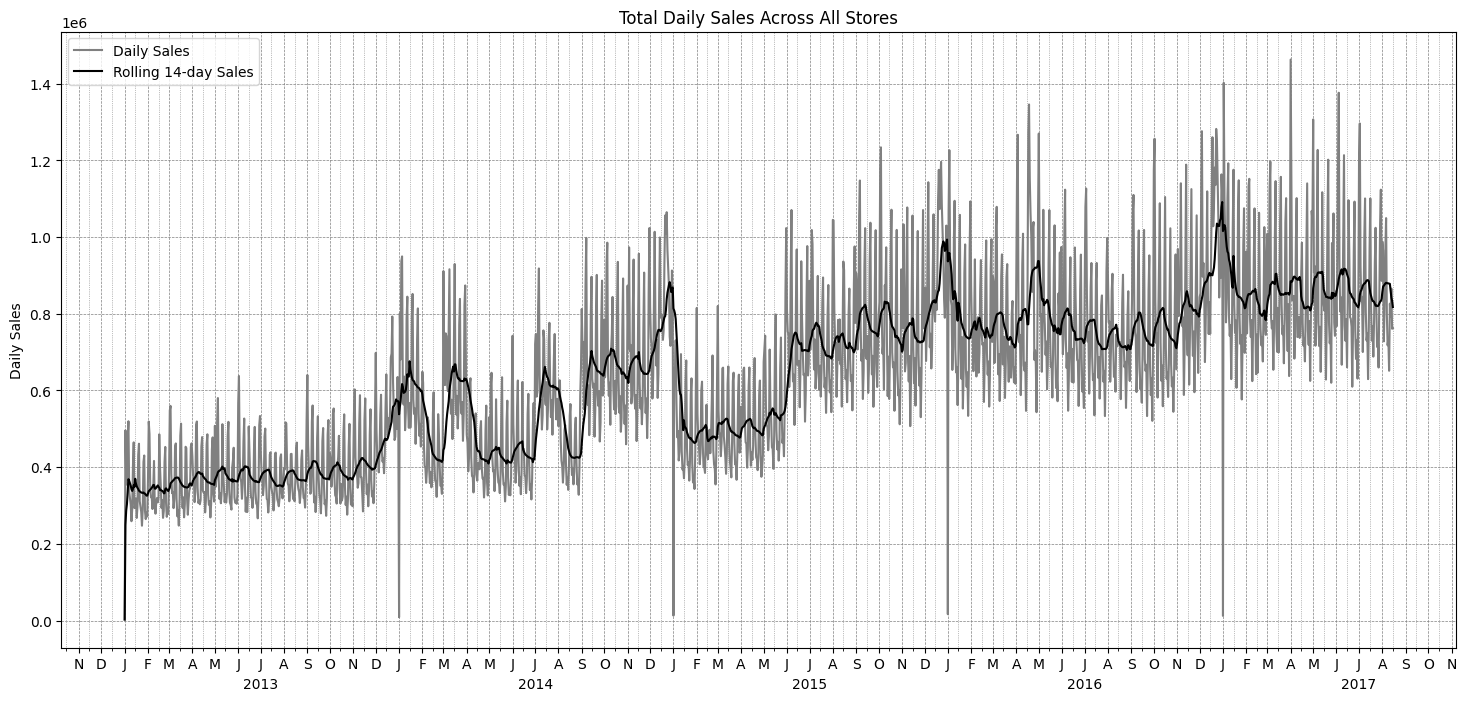

In [42]:
fig, ax = plt.subplots(figsize = (18,8))
sns.lineplot(data = total_daily_sales_df, x = 'date', y= 'sales', color='grey', label= 'Daily Sales', ax=ax)
sns.lineplot(data = total_daily_sales_df, x = 'date', y= 'rolling_avg', color='black', label = 'Rolling 14-day Sales', ax=ax)
# ax2=ax.twinx()
# sns.lineplot(data=oil_df, x='date', y='oil_price', color='darkblue', label='oil price', ax=ax2)
ax.set_title('Total Daily Sales Across All Stores')
ax.set_ylabel('Daily Sales')
ax.set_xlabel('')
# ax2.set_ylabel('Oil Price')

# ax2.set_ylim(0,200)
# ax2.set_yscale('log')

# Format the x-axis
ax.xaxis.set_major_locator(MonthLocator(interval=1))  # Set major ticks at every month
ax.xaxis.set_major_formatter(FuncFormatter(format_month_name))  # Abbreviated month names

# Add minor gridlines at 15-day intervals
ax.xaxis.set_minor_locator(MonthLocator(bymonthday=15))
ax.xaxis.grid(True, which='minor', linestyle='dotted', linewidth=0.5, color='grey')

# add major gridlines
ax.xaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color = 'grey')
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color = 'grey')

# Add year labels manually
years = total_daily_sales_df.select(pl.col("date").dt.year().unique()).to_series()  # Unique years
year_positions = [total_daily_sales_df.filter(total_daily_sales_df['date'].dt.year() == year).select(pl.col('date'))[0].item() + relativedelta(months=6) for year in years]


# Set the x-ticks to correspond to the dates and adjust the tick positions for better alignment
# ax.set_xticks(year_positions)
# ax.set_xticklabels([])  # Empty list to remove the default x-axis labels
for pos, year in zip(year_positions, years):
    ax.text(pos, ax.get_ylim()[0] - ax.get_ylim()[1]*0.05, year, ha='center', va='top')  # Add the year text below the x-axis

plt.grid(True)


In [43]:
train_df = train_df.with_columns((pl.col('date').dt.weekday().alias('weekday')))

# Aggregate sales by date
daily_sales = train_df.group_by(['date', 'weekday'], maintain_order=True).agg(pl.col('sales').sum())

# Separate weekday and weekend sales
weekday_sales = daily_sales.filter(pl.col('weekday')<=5)
weekend_sales = daily_sales.filter(pl.col('weekday')>5)


weekday_sales = weekday_sales.with_columns(avg_sales=pl.col("sales").rolling_mean(window_size=5, min_periods=5))
weekend_sales = weekend_sales.with_columns(avg_sales=pl.col("sales").rolling_mean(window_size=2, min_periods=2))


weekday_sales = weekday_sales.with_columns(pl.lit('Weekday').alias('day_type'))
weekend_sales = weekend_sales.with_columns(pl.lit('Weekend').alias('day_type'))

# Combine the dataframes
combined_sales = pl.concat([weekday_sales, weekend_sales])

day_labels = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
combined_sales = combined_sales.select(
    pl.col('weekday').map_elements(lambda x: day_labels[x], return_dtype=pl.Utf8),
    pl.exclude('weekday')
)
print(combined_sales)



shape: (1_684, 5)
┌───────────┬────────────┬───────────────┬───────────────┬──────────┐
│ weekday   ┆ date       ┆ sales         ┆ avg_sales     ┆ day_type │
│ ---       ┆ ---        ┆ ---           ┆ ---           ┆ ---      │
│ str       ┆ date       ┆ f64           ┆ f64           ┆ str      │
╞═══════════╪════════════╪═══════════════╪═══════════════╪══════════╡
│ Tuesday   ┆ 2013-01-01 ┆ 2511.618999   ┆ null          ┆ Weekday  │
│ Wednesday ┆ 2013-01-02 ┆ 496092.417944 ┆ null          ┆ Weekday  │
│ Thursday  ┆ 2013-01-03 ┆ 361461.231124 ┆ null          ┆ Weekday  │
│ Friday    ┆ 2013-01-04 ┆ 354459.677093 ┆ null          ┆ Weekday  │
│ Monday    ┆ 2013-01-07 ┆ 336122.801066 ┆ 310129.549245 ┆ Weekday  │
│ Tuesday   ┆ 2013-01-08 ┆ 318347.777981 ┆ 373296.781042 ┆ Weekday  │
│ Wednesday ┆ 2013-01-09 ┆ 302530.809018 ┆ 334584.459256 ┆ Weekday  │
│ Thursday  ┆ 2013-01-10 ┆ 258982.003049 ┆ 314088.613641 ┆ Weekday  │
│ …         ┆ …          ┆ …             ┆ …             ┆ …        │
│ 

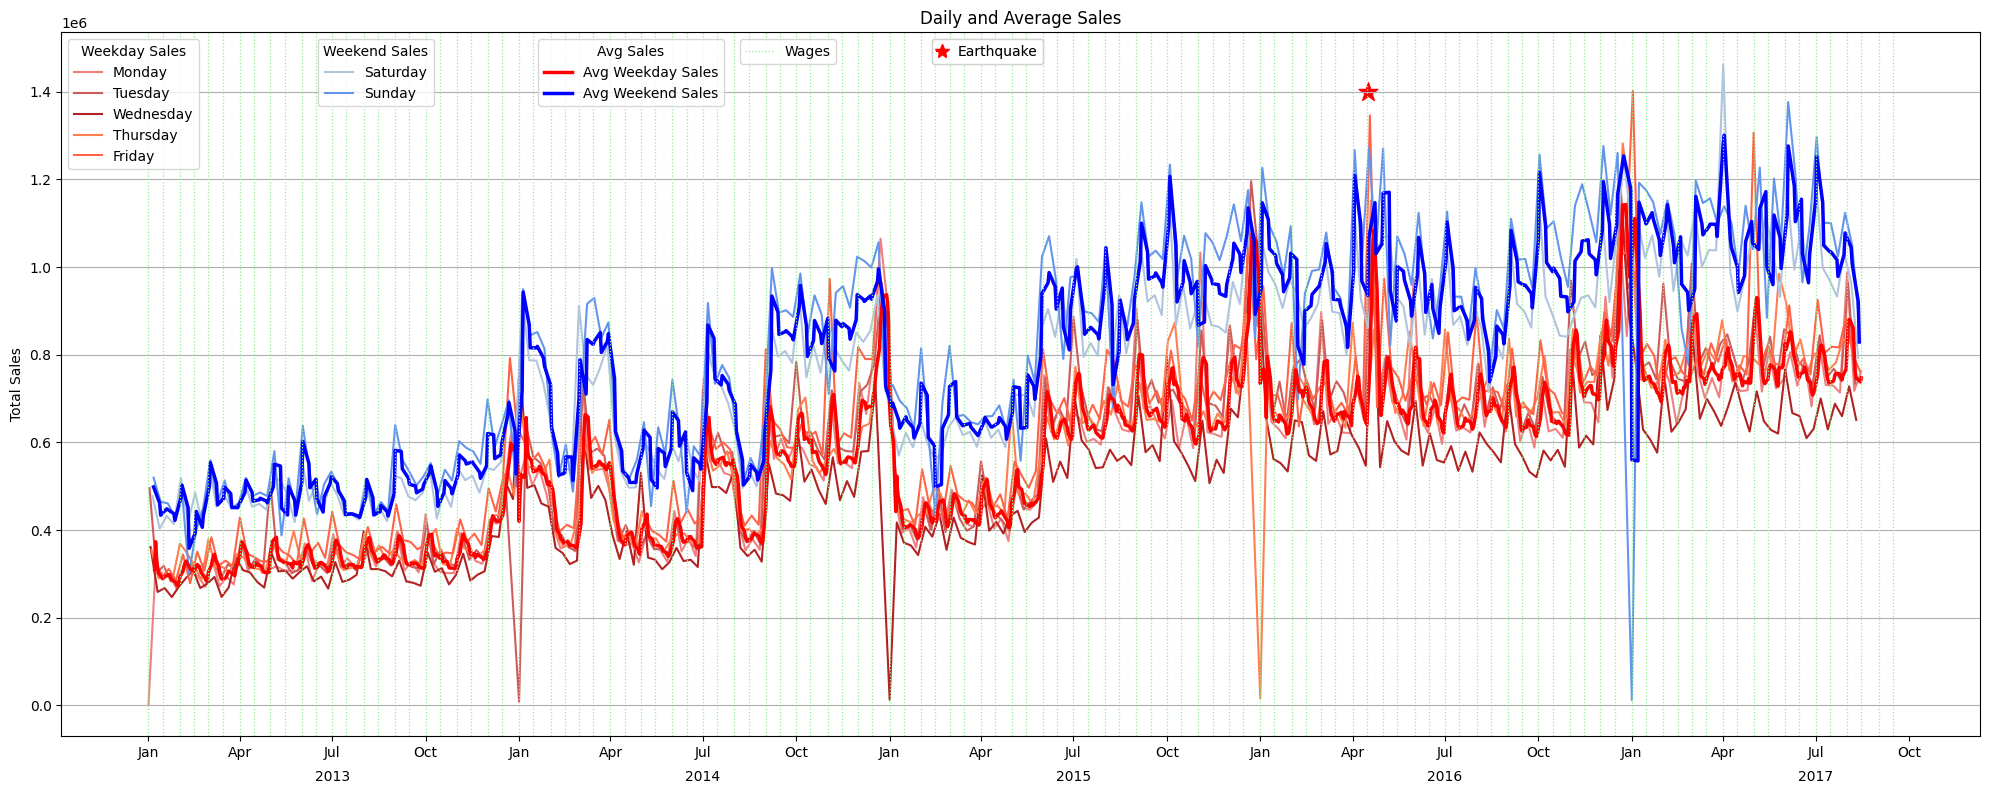

In [44]:


# Create plot
fig, ax = plt.subplots(figsize=(20, 8))

# Define weekday labels and colors

weekday_colors = ['lightcoral', 'indianred', 'firebrick', 'coral', 'tomato']
weekend_colors = ['lightsteelblue', 'cornflowerblue']
colors = weekday_colors + weekend_colors



# Plot total sales
sales_plot = sns.lineplot(x='date', y='sales', hue='weekday', data=combined_sales, palette=colors, ax=ax)

# Plot average sales
avg_weekday_plot = sns.lineplot(x='date', y='avg_sales', data=weekday_sales, color='red', linewidth=2.5, ax=ax)
avg_weekend_plot = sns.lineplot(x='date', y='avg_sales', data=weekend_sales, color='blue', linewidth=2.5, ax=ax)

# Create custom legends for weekdays and weekends
weekday_legend = plt.legend(handles=sales_plot.get_lines()[:5], labels=day_labels[1:6], title='Weekday Sales', loc='upper left')
weekend_legend = plt.legend(handles=sales_plot.get_lines()[5:8], labels=day_labels[6:], title='Weekend Sales', loc='upper left', bbox_to_anchor=(0.13, 1))

# Combine the legends into a single legend box
avg_sales_legend = plt.legend(handles=[
    Line2D([0], [0], color='red', linewidth=2.5, label='Avg Weekday Sales'),
    Line2D([0], [0], color='blue', linewidth=2.5, label='Avg Weekend Sales')
], title='Avg Sales', loc='upper left', bbox_to_anchor=(0.245, 1))

# Add legends to the plot
ax.add_artist(weekday_legend)
ax.add_artist(weekend_legend)

# Add the combined legend box to the plot
ax.add_artist(avg_sales_legend)

plt.xlabel('')
plt.ylabel('Total Sales')
plt.title('Daily and Average Sales')
plt.grid(True)
# Rotate the x-axis tick labels by 45 degrees
plt.xticks(rotation=0)
# Format the x-axis
ax.xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))  # Set major ticks at every month
ax.xaxis.set_major_formatter(DateFormatter('%b'))  # Abbreviated month names


# Add year labels manually
years = total_daily_sales_df.select(pl.col("date").dt.year().unique()).to_series()  # Unique years
year_positions = [total_daily_sales_df.filter(total_daily_sales_df['date'].dt.year() == year).select(pl.col('date'))[0].item() + relativedelta(months=6) for year in years]


# Set the x-ticks to correspond to the dates and adjust the tick positions for better alignment
for pos, year in zip(year_positions, years):
    ax.text(pos, ax.get_ylim()[0] - ax.get_ylim()[1]*0.05, year, ha='center', va='top')  # Add the year text below the x-axis

# Add vertical lines for wages (1st and 15th of every month)
wages_1st_dates = pd.date_range(start='2013-01-01', end='2017-09-01', freq='MS')
wages_15th_dates = pd.date_range(start='2013-01-01', end='2017-09-01', freq='MS') + pd.Timedelta(days=14)

for wage_date in wages_1st_dates:
    ax.axvline(wage_date, color='lightgreen', linestyle='dotted', alpha=1.0, label='Wages', linewidth = 0.9)
    
for wage_date in wages_15th_dates:
    ax.axvline(wage_date, color='lightgreen', linestyle='dotted', alpha=1.0, linewidth = 0.9)



# Create custom legend for wage days
wage_legend = plt.legend(handles=[
    Line2D([0], [0], color='lightgreen', linestyle='dotted', alpha=1.0, linewidth=0.9, label='Wages')
], loc='upper left', bbox_to_anchor=(0.35, 1.0))

# Add the wage day legend to the plot
ax.add_artist(wage_legend)

# Add earthquake event marker
earthquake_date = pd.to_datetime('2016-04-16')
earthquake_sales = combined_sales.filter(pl.col('date')==earthquake_date)
ax.scatter(earthquake_date, 1.4e6, marker='*', color='red', s=200, label='Earthquake')

# Create custom legend for the earthquake event
earthquake_legend = plt.legend(handles=[
    Line2D([], [], marker='*', color='red', markersize=10, label='Earthquake')
], loc='upper left', bbox_to_anchor=(0.45, 1.0), handlelength=0.7)

# Add the earthquake legend to the plot
ax.add_artist(earthquake_legend)

# Turn off x-axis major gridlines
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()



In [45]:


train_df = train_df.with_columns(
    pl.col('date').dt.month().alias('month'),
    pl.col('date').dt.quarter().alias('quarter'),
    pl.col('date').dt.year().alias('year'),
    pl.col('date').dt.day().alias('day')
)

train_df = train_df.select(
    pl.col('month').map_elements(lambda x: calendar.month_name[x], return_dtype=pl.Utf8),
    pl.col('quarter').map_elements(lambda x: 'Q'+f'{x}', return_dtype=pl.Utf8),
    pl.col('weekday').map_elements(lambda x: day_labels[x], return_dtype=pl.Utf8).alias('dayofweek'),
    pl.exclude(['month', 'quarter', 'weekday'])
)

print(train_df)


shape: (3_000_888, 11)
┌─────────┬─────────┬───────────┬─────────┬────────────┬───────────┬────────────────────────────┬──────────┬─────────────┬──────┬─────┐
│ month   ┆ quarter ┆ dayofweek ┆ id      ┆ date       ┆ store_nbr ┆ family                     ┆ sales    ┆ onpromotion ┆ year ┆ day │
│ ---     ┆ ---     ┆ ---       ┆ ---     ┆ ---        ┆ ---       ┆ ---                        ┆ ---      ┆ ---         ┆ ---  ┆ --- │
│ str     ┆ str     ┆ str       ┆ i64     ┆ date       ┆ str       ┆ str                        ┆ f64      ┆ i64         ┆ i32  ┆ i8  │
╞═════════╪═════════╪═══════════╪═════════╪════════════╪═══════════╪════════════════════════════╪══════════╪═════════════╪══════╪═════╡
│ January ┆ Q1      ┆ Tuesday   ┆ 0       ┆ 2013-01-01 ┆ 1         ┆ AUTOMOTIVE                 ┆ 0.0      ┆ 0           ┆ 2013 ┆ 1   │
│ January ┆ Q1      ┆ Tuesday   ┆ 1       ┆ 2013-01-01 ┆ 1         ┆ BABY CARE                  ┆ 0.0      ┆ 0           ┆ 2013 ┆ 1   │
│ January ┆ Q1      ┆ Tue

In [46]:
q = (
    train_df.lazy().with_columns(pl.col('date').dt.round(every='1mo'))
    .group_by('date', maintain_order=True).agg(pl.col('sales').sum())

)
monthly_df = q.collect()

q = (
    monthly_df.lazy().with_columns(pl.col('date').dt.round(every='1q'))
    .group_by('date', maintain_order=True).agg(pl.col('sales').mean())

)
quarterly_df = q.collect()
print(quarterly_df)

shape: (19, 2)
┌────────────┬──────────┐
│ date       ┆ sales    │
│ ---        ┆ ---      │
│ date       ┆ f64      │
╞════════════╪══════════╡
│ 2013-01-01 ┆ 7.6300e6 │
│ 2013-04-01 ┆ 1.1222e7 │
│ 2013-07-01 ┆ 1.1532e7 │
│ 2013-10-01 ┆ 1.1843e7 │
│ 2014-01-01 ┆ 1.5487e7 │
│ 2014-04-01 ┆ 1.5546e7 │
│ 2014-07-01 ┆ 1.5453e7 │
│ 2014-10-01 ┆ 1.9299e7 │
│ …          ┆ …        │
│ 2016-01-01 ┆ 2.4330e7 │
│ 2016-04-01 ┆ 2.4507e7 │
│ 2016-07-01 ┆ 2.2992e7 │
│ 2016-10-01 ┆ 2.3304e7 │
│ 2017-01-01 ┆ 2.6346e7 │
│ 2017-04-01 ┆ 2.6308e7 │
│ 2017-07-01 ┆ 2.5664e7 │
└────────────┴──────────┘


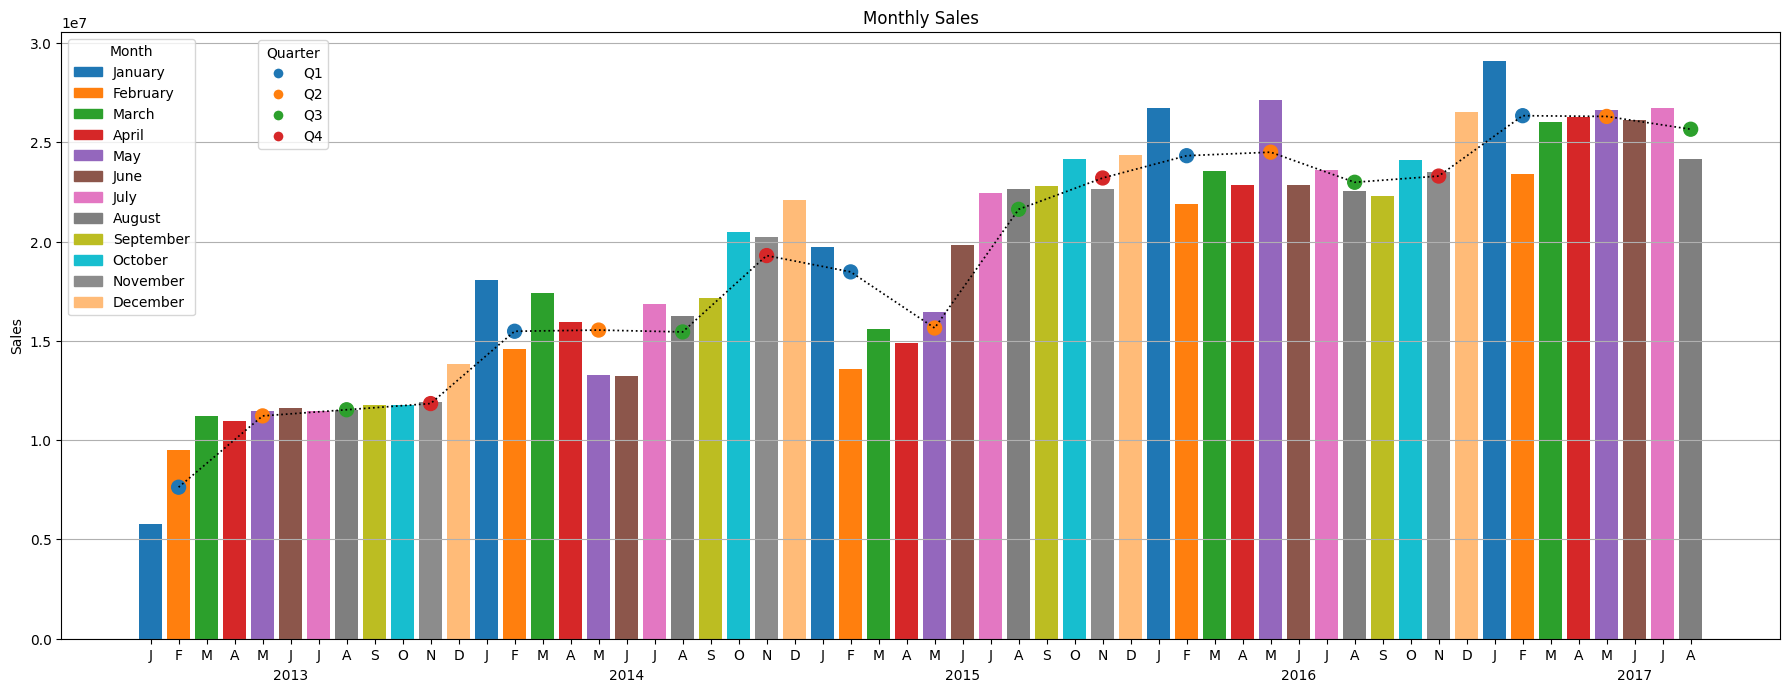

In [47]:

# Tableau color palettes
# Define custom Tableau-like color palettes
# Tableau 20-like palette for months
month_palette = [
    (31, 119, 180), (255, 127, 14), (44, 160, 44), (214, 39, 40), 
    (148, 103, 189), (140, 86, 75), (227, 119, 194), (127, 127, 127), 
    (188, 189, 34), (23, 190, 207), (140, 140, 140), (255, 187, 120)
]
month_palette = [(r / 255, g / 255, b / 255) for r, g, b in month_palette]

# Tableau 10-like palette for quarters
quarter_palette = [
    (31, 119, 180), (255, 127, 14), (44, 160, 44), (214, 39, 40)
]
quarter_palette = [(r / 255, g / 255, b / 255) for r, g, b in quarter_palette]


# Create a bar plot of the sales data
fig, ax = plt.subplots(figsize=(18, 7))

# We use numpy's arange function to ensure that the bars are placed at the correct x locations
ax.bar(np.arange(len(monthly_df)), monthly_df.select(pl.col('sales')).to_series(), color=[month_palette[value-1] for value in monthly_df.select(pl.col('date').dt.month()).to_series()])


# Change the legend labels to month names
month_handles = [plt.Rectangle((0,0),1,1, color=month_palette[i]) for i in range(12)]
month_labels = [calendar.month_name[i+1] for i in range(12)]
month_legend = ax.legend(month_handles, month_labels, title='Month', loc='upper left')

# Add the legend back after creating the second legend
plt.gca().add_artist(month_legend)

# The positions of the markers (quarters) are calculated by taking the first position of the corresponding months
# quarter_positions = [np.where((monthly_df['date'].dt.year == year) & (monthly_df['date'].dt.quarter == quarter))[0][1] for year, quarter in zip(quarterly_df['date'].dt.year, quarterly_df['date'].dt.quarter)]
quarter_positions = [np.where(((monthly_df.select(pl.col('date').dt.year()).to_series()) == year) & ((monthly_df.select(pl.col('date').dt.month()).to_series()) == quarter+1))[0][0] \
    for year, quarter in zip(quarterly_df.select(pl.col('date').dt.year()).to_series(), quarterly_df.select(pl.col('date').dt.month()).to_series())]
quarter_colors = [quarter_palette[q-1] for q in quarterly_df.select(pl.col('date').dt.quarter()).to_series()]
# ax.scatter(quarter_positions, quarterly_df['sales'], marker='o', color=quarter_colors, s=100, label='Average Quarterly Sales')

ax.scatter(quarter_positions, quarterly_df.select(pl.col('sales')).to_series(), marker='o', color=quarter_colors, s=100, label='_nolegend_')
ax.plot(quarter_positions, quarterly_df.select(pl.col('sales')).to_series(), linestyle=':', linewidth=1.25, color='black')


# Change the legend labels to quarter names
quarter_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=quarter_palette[i], markersize=8) for i in range(4)]
quarter_labels = ['Q1', 'Q2', 'Q3', 'Q4']
ax.legend(quarter_handles, quarter_labels, title='Quarter', loc='upper center', bbox_to_anchor=(0.135, 0.998), ncol=1)

# Set the x-ticks to correspond to the dates and format them to the initial of the month names
ax.set_xticks(np.arange(len(monthly_df)))
ax.set_xticklabels(monthly_df.select(pl.col('date').dt.strftime('%b').map_elements(lambda x: x[0], return_dtype=pl.Utf8)).to_series())

# Remove minor gridlines from x-axis and y-axis
ax.grid(False, which='minor')

# # Add year labels manually
years = total_daily_sales_df.select(pl.col("date").dt.year().unique()).to_series()  # Unique years
year_positions = np.arange(5,len(monthly_df),12)

for pos, year in zip(year_positions, years):
    ax.text(pos, ax.get_ylim()[0] - ax.get_ylim()[1]*0.05, year, ha='center', va='top')  # Add the year text below the x-axis

plt.ylabel('Sales')
plt.title('Monthly Sales')
plt.grid(True, axis='y')  # Keep y-axis gridlines
plt.tight_layout()
plt.show();


#### Which products had the highest sales

In [48]:
store_sales = train_df.group_by(pl.col('store_nbr')).agg(pl.col('sales').sum())
# sorted_store_nbr = store_sales.sort('sales').select(pl.col('store_nbr')).unique()
sorted_store_nbr = store_sales.sort('sales', descending = True).select(pl.col('store_nbr')).to_series()
print(store_sales)

shape: (54, 2)
┌───────────┬──────────┐
│ store_nbr ┆ sales    │
│ ---       ┆ ---      │
│ str       ┆ f64      │
╞═══════════╪══════════╡
│ 15        ┆ 1.1451e7 │
│ 7         ┆ 2.6952e7 │
│ 40        ┆ 1.8396e7 │
│ 54        ┆ 1.1057e7 │
│ 47        ┆ 5.0948e7 │
│ 32        ┆ 5.9518e6 │
│ 27        ┆ 1.9188e7 │
│ 13        ┆ 1.0523e7 │
│ …         ┆ …        │
│ 48        ┆ 3.5933e7 │
│ 23        ┆ 1.1651e7 │
│ 22        ┆ 4.0902e6 │
│ 12        ┆ 1.0659e7 │
│ 49        ┆ 4.3420e7 │
│ 31        ┆ 1.7747e7 │
│ 11        ┆ 2.8326e7 │
└───────────┴──────────┘


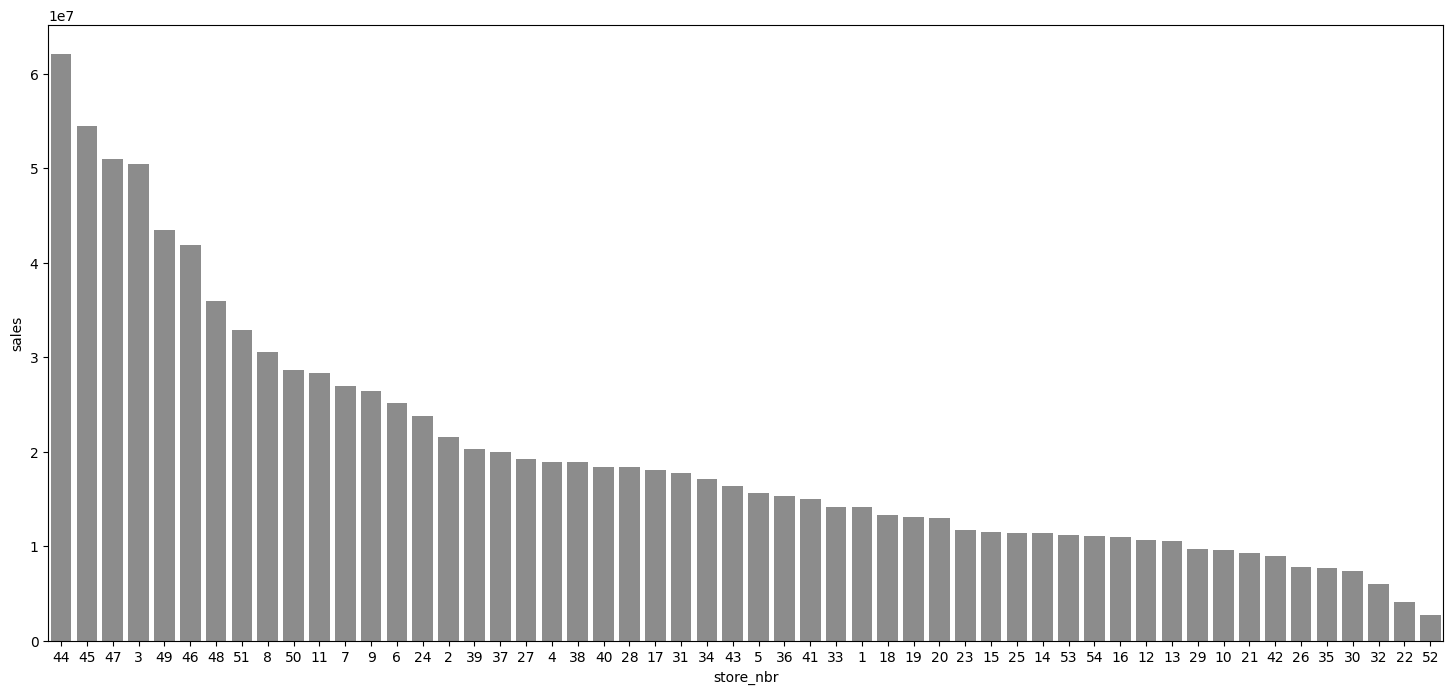

In [49]:

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (18,8))

sns.barplot(x ='store_nbr', y ='sales', data = store_sales.to_pandas(), ax=ax, order = sorted_store_nbr, color= month_palette[10])
plt.show();


#### Which product family had the highest sales across all stores?

In [50]:
family_sales = train_df.group_by('family', maintain_order=True).agg(pl.col('sales').sum()).sort(pl.col('sales'), descending=True)
print(family_sales)

shape: (33, 2)
┌────────────────────────────┬──────────────┐
│ family                     ┆ sales        │
│ ---                        ┆ ---          │
│ str                        ┆ f64          │
╞════════════════════════════╪══════════════╡
│ GROCERY I                  ┆ 3.4346e8     │
│ BEVERAGES                  ┆ 2.16954486e8 │
│ PRODUCE                    ┆ 1.2270e8     │
│ CLEANING                   ┆ 9.7521289e7  │
│ DAIRY                      ┆ 6.4487709e7  │
│ BREAD/BAKERY               ┆ 4.2134e7     │
│ POULTRY                    ┆ 3.1876e7     │
│ MEATS                      ┆ 3.1086e7     │
│ …                          ┆ …            │
│ BEAUTY                     ┆ 337893.0     │
│ SCHOOL AND OFFICE SUPPLIES ┆ 269316.0     │
│ MAGAZINES                  ┆ 266359.0     │
│ HARDWARE                   ┆ 103470.0     │
│ HOME APPLIANCES            ┆ 41601.0      │
│ BABY CARE                  ┆ 10051.0      │
│ BOOKS                      ┆ 6438.0       │
└──────────────────

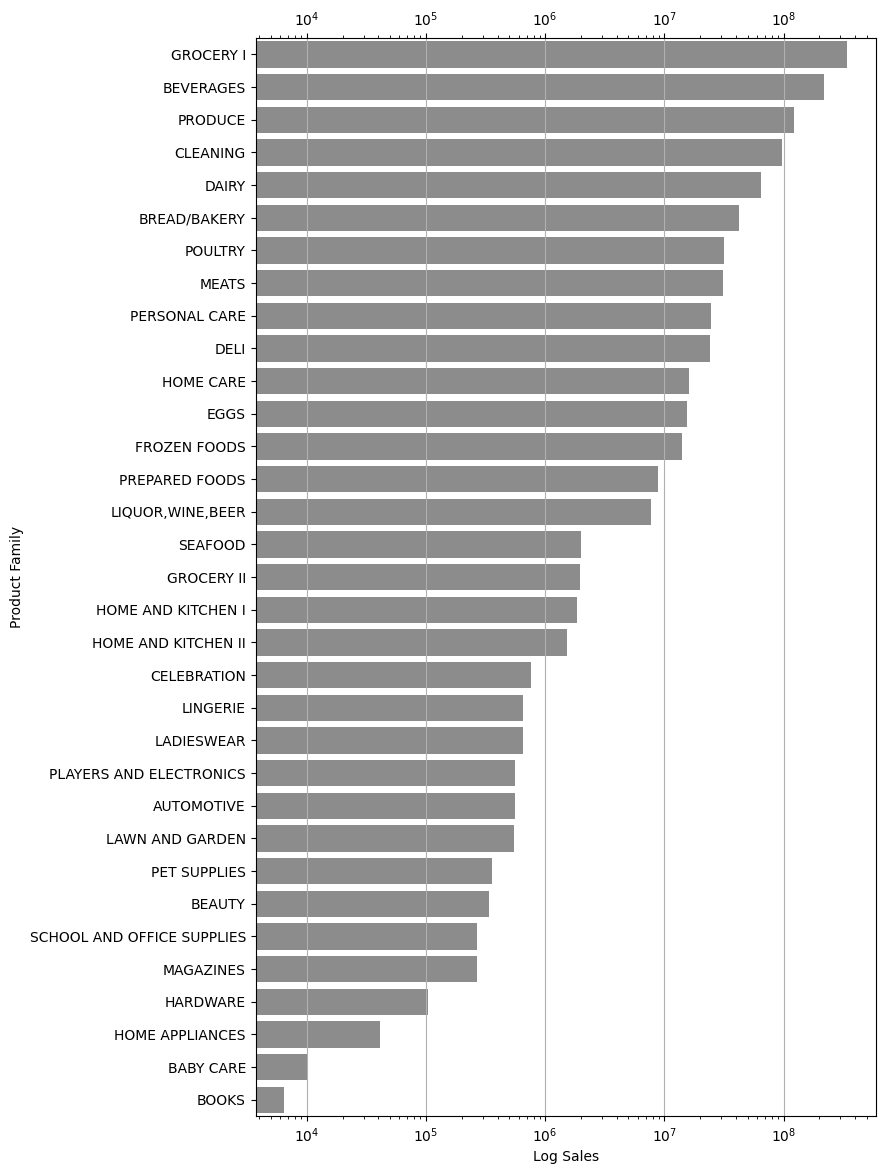

In [51]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8,14))
snl.barplot(family_sales, x ='sales', y = 'family', color=month_palette[10], log=True ,ax=ax)
# Enable minor gridlines on the x-axis only
ax.xaxis.grid(True, which='major')
# Show the axis scale on both top and bottom
# ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x', which = 'both', top=True, bottom=True, labelrotation=0, labeltop=True, labelbottom=True)

ax.set_xlabel('Log Sales')
ax.set_ylabel('Product Family')
plt.show;
# 

In [52]:
train_df = train_df.with_columns(pl.col('year').cast(pl.Utf8),pl.col('day').cast(pl.Utf8))
grouped_monthly_sales_df=train_df.group_by('month', maintain_order=True).agg(pl.col('sales').sum())
grouped_quarterly_sales_df=train_df.group_by('quarter', maintain_order=True).agg(pl.col('sales').sum())
grouped_yearly_sales_df=train_df.group_by('year', maintain_order=True).agg(pl.col('sales').sum())
grouped_dayofweek_sales_df=train_df.group_by('dayofweek', maintain_order=True).agg(pl.col('sales').sum())
grouped_day_sales_df=train_df.group_by('day', maintain_order=True).agg(pl.col('sales').sum())
print(grouped_day_sales_df)

shape: (31, 2)
┌─────┬──────────┐
│ day ┆ sales    │
│ --- ┆ ---      │
│ str ┆ f64      │
╞═════╪══════════╡
│ 1   ┆ 3.9875e7 │
│ 2   ┆ 4.1635e7 │
│ 3   ┆ 4.0132e7 │
│ 4   ┆ 3.9199e7 │
│ 5   ┆ 3.8296e7 │
│ 6   ┆ 3.7228e7 │
│ 7   ┆ 3.6339e7 │
│ 8   ┆ 3.5135e7 │
│ …   ┆ …        │
│ 25  ┆ 2.9672e7 │
│ 26  ┆ 3.2883e7 │
│ 27  ┆ 3.2233e7 │
│ 28  ┆ 3.2797e7 │
│ 29  ┆ 3.1429e7 │
│ 30  ┆ 3.2732e7 │
│ 31  ┆ 2.2213e7 │
└─────┴──────────┘


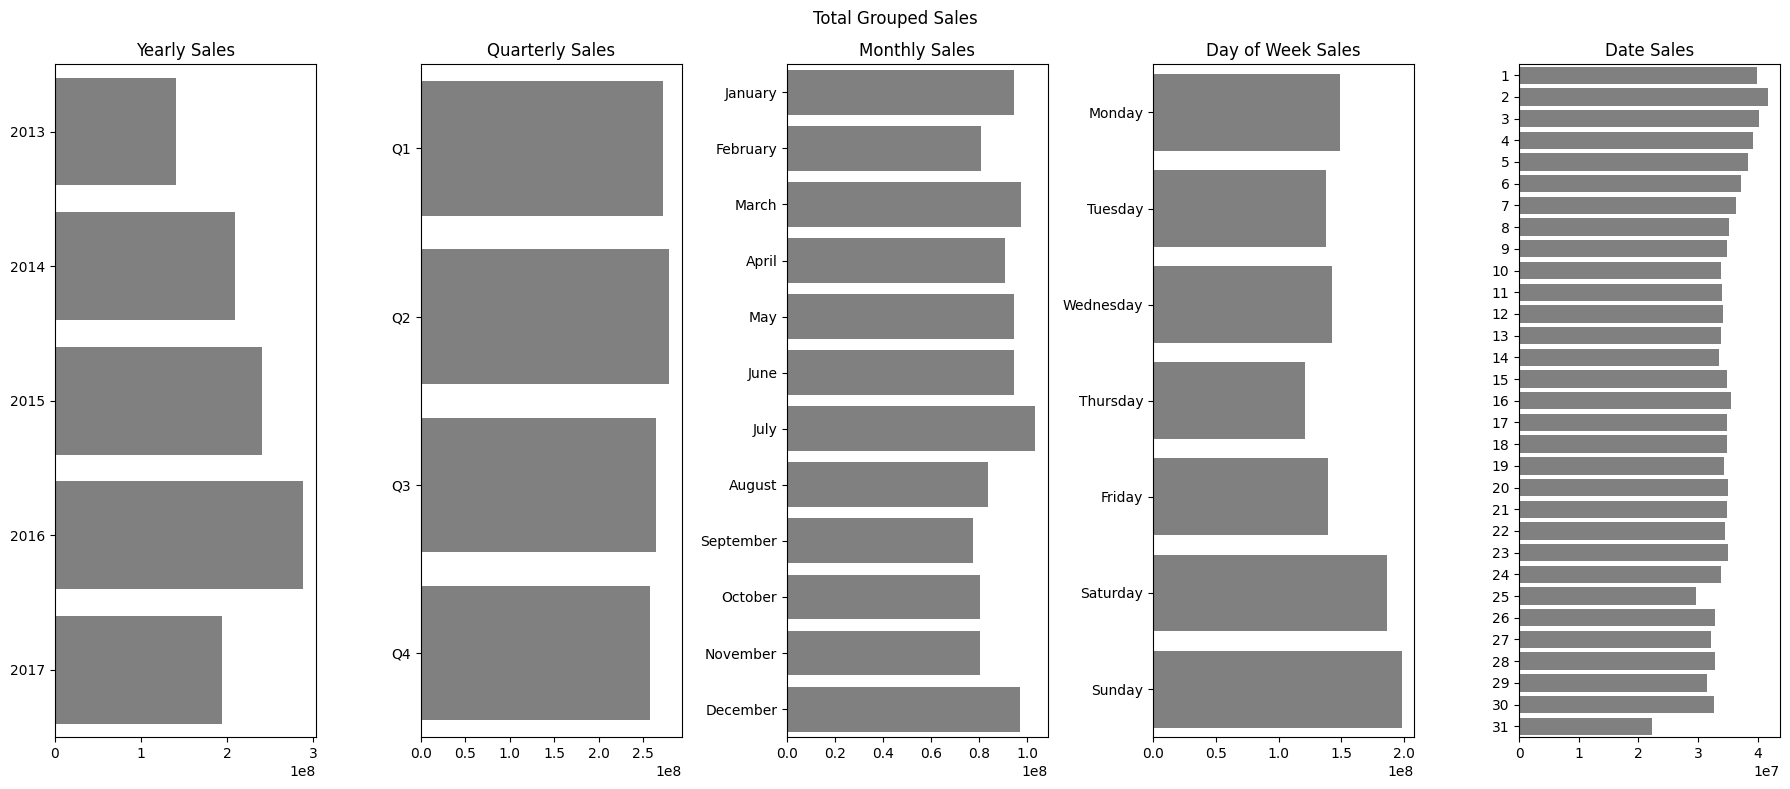

In [53]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(18,8))
snl.barplot(grouped_yearly_sales_df, x='sales', y='year', color='grey',  ax=ax1)
snl.barplot(grouped_quarterly_sales_df, x='sales', y='quarter', color='grey', order=['Q1', 'Q2', 'Q3', 'Q4'], ax=ax2)
snl.barplot(grouped_monthly_sales_df, x='sales', y='month', color='grey', order=months_list, ax=ax3)
snl.barplot(grouped_dayofweek_sales_df, x='sales', y='dayofweek', color='grey', order=day_names, ax=ax4)
snl.barplot(grouped_day_sales_df, x='sales', y='day', color='grey',  order=day_string, ax=ax5)

ax1.set_title('Yearly Sales')
ax2.set_title('Quarterly Sales')
ax3.set_title('Monthly Sales')
ax4.set_title('Day of Week Sales')
ax5.set_title('Date Sales')

# Turn off x and y-axis labels
ax1.set(xlabel='', ylabel='')
ax2.set(xlabel='', ylabel='')
ax3.set(xlabel='', ylabel='')
ax4.set(xlabel='', ylabel='')
ax5.set(xlabel='', ylabel='')

fig.suptitle('Total Grouped Sales')
fig.tight_layout()

In [54]:
promotion_df = train_df.group_by('family').agg(pl.col('onpromotion').sum()).sort(pl.col('onpromotion'), descending=True)
print(promotion_df)

shape: (33, 2)
┌─────────────────────────┬─────────────┐
│ family                  ┆ onpromotion │
│ ---                     ┆ ---         │
│ str                     ┆ i64         │
╞═════════════════════════╪═════════════╡
│ GROCERY I               ┆ 1914801     │
│ PRODUCE                 ┆ 1117921     │
│ BEVERAGES               ┆ 906958      │
│ DAIRY                   ┆ 728707      │
│ CLEANING                ┆ 661157      │
│ DELI                    ┆ 583316      │
│ BREAD/BAKERY            ┆ 331289      │
│ MEATS                   ┆ 304028      │
│ …                       ┆ …           │
│ PLAYERS AND ELECTRONICS ┆ 1874        │
│ LADIESWEAR              ┆ 1680        │
│ MAGAZINES               ┆ 297         │
│ HARDWARE                ┆ 163         │
│ HOME APPLIANCES         ┆ 58          │
│ BABY CARE               ┆ 53          │
│ BOOKS                   ┆ 0           │
└─────────────────────────┴─────────────┘


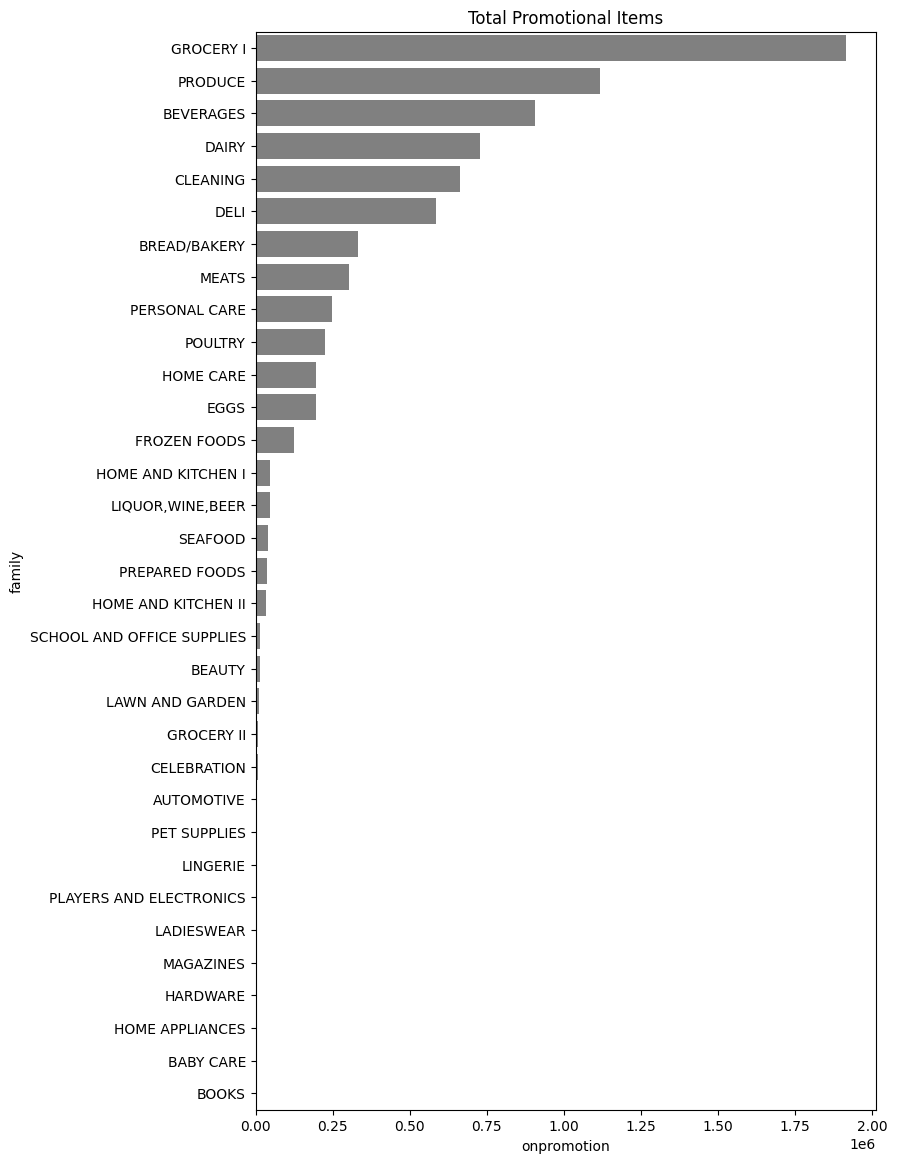

In [55]:
fig, ax = plt.subplots(figsize = (8,14))
snl.barplot(promotion_df, x='onpromotion', y = 'family', color='grey', ax=ax)
ax.set_title('Total Promotional Items')
plt.show();

In [56]:
promotion_trend_df = train_df.group_by('date', maintain_order=True).agg(pl.col('onpromotion').sum())
window_size=14
promotion_trend_df = promotion_trend_df.with_columns(rolling_avg=pl.col("onpromotion").rolling_mean(window_size=window_size, min_periods=1))
print(promotion_trend_df)

shape: (1_684, 3)
┌────────────┬─────────────┬──────────────┐
│ date       ┆ onpromotion ┆ rolling_avg  │
│ ---        ┆ ---         ┆ ---          │
│ date       ┆ i64         ┆ f64          │
╞════════════╪═════════════╪══════════════╡
│ 2013-01-01 ┆ 0           ┆ 0.0          │
│ 2013-01-02 ┆ 0           ┆ 0.0          │
│ 2013-01-03 ┆ 0           ┆ 0.0          │
│ 2013-01-04 ┆ 0           ┆ 0.0          │
│ 2013-01-05 ┆ 0           ┆ 0.0          │
│ 2013-01-06 ┆ 0           ┆ 0.0          │
│ 2013-01-07 ┆ 0           ┆ 0.0          │
│ 2013-01-08 ┆ 0           ┆ 0.0          │
│ …          ┆ …           ┆ …            │
│ 2017-08-09 ┆ 16117       ┆ 10840.357143 │
│ 2017-08-10 ┆ 7917        ┆ 10834.357143 │
│ 2017-08-11 ┆ 14179       ┆ 10857.857143 │
│ 2017-08-12 ┆ 8312        ┆ 10801.642857 │
│ 2017-08-13 ┆ 9283        ┆ 10734.214286 │
│ 2017-08-14 ┆ 8043        ┆ 10690.928571 │
│ 2017-08-15 ┆ 10605       ┆ 10723.428571 │
└────────────┴─────────────┴──────────────┘


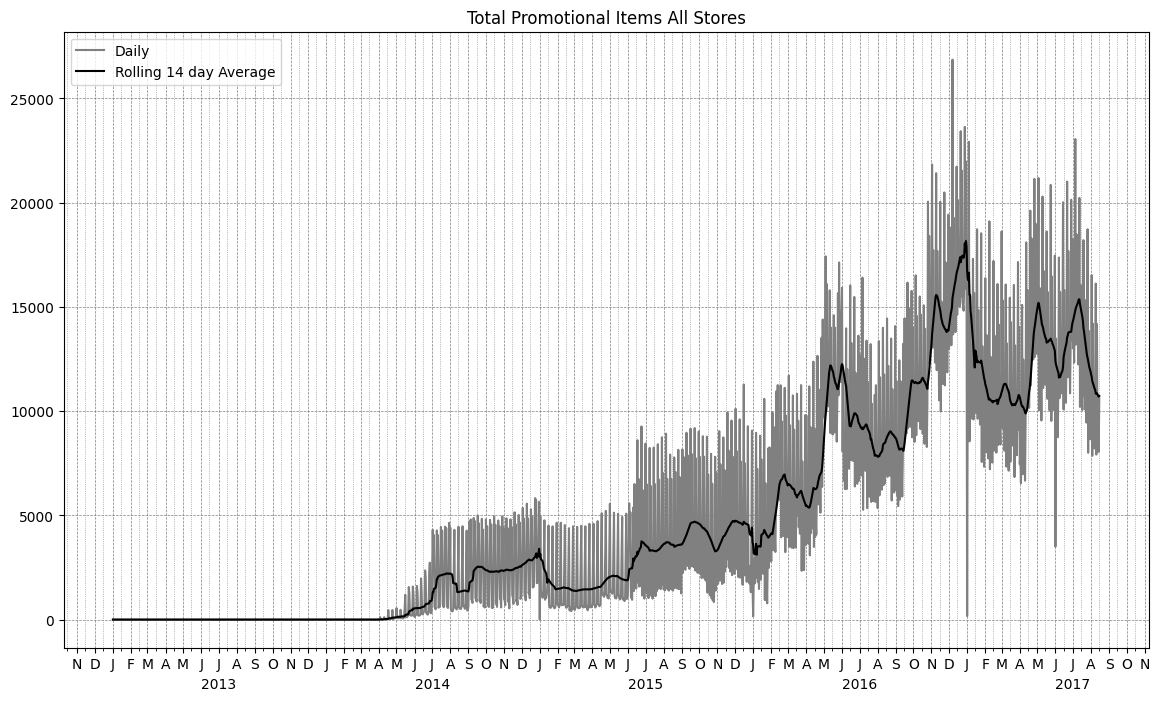

In [57]:
fig, ax = plt.subplots(figsize = (14,8))
sns.lineplot(data=promotion_trend_df.to_pandas(), x = 'date', y = 'onpromotion', color = 'grey', label = 'Daily', ax=ax)
sns.lineplot(data=promotion_trend_df.to_pandas(), x = 'date', y = 'rolling_avg', color = 'black', label = f'Rolling {window_size} day Average', ax=ax)
ax.set_title('Total Promotional Items All Stores')
ax.set_xlabel('')
ax.set_ylabel('')


# Format the x-axis
ax.xaxis.set_major_locator(MonthLocator(interval=1))  # Set major ticks at every month
ax.xaxis.set_major_formatter(FuncFormatter(format_month_name))  # Abbreviated month names

# Add minor gridlines at 15-day intervals
ax.xaxis.set_minor_locator(MonthLocator(bymonthday=15))
ax.xaxis.grid(True, which='minor', linestyle='dotted', linewidth=0.5, color='grey')

# add major gridlines
ax.xaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color = 'grey')
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color = 'grey')

# Add year labels manually
years = promotion_trend_df.select(pl.col("date").dt.year().unique()).to_series()  # Unique years
year_positions = [promotion_trend_df.filter(promotion_trend_df['date'].dt.year() == year).select(pl.col('date'))[0].item() + relativedelta(months=6) for year in years]


# Set the x-ticks to correspond to the dates and adjust the tick positions for better alignment
for pos, year in zip(year_positions, years):
    ax.text(pos, ax.get_ylim()[0] - ax.get_ylim()[1]*0.05, year, ha='center', va='top')  # Add the year text below the x-axis


plt.grid(True)
plt.show();


In [58]:
promotion_stores_df = train_df.group_by('store_nbr', maintain_order=True).agg(pl.col('onpromotion').sum()).sort('onpromotion', descending=True)
print(promotion_stores_df)

shape: (54, 2)
┌───────────┬─────────────┐
│ store_nbr ┆ onpromotion │
│ ---       ┆ ---         │
│ str       ┆ i64         │
╞═══════════╪═════════════╡
│ 53        ┆ 204016      │
│ 47        ┆ 192725      │
│ 44        ┆ 192449      │
│ 45        ┆ 191503      │
│ 46        ┆ 190697      │
│ 48        ┆ 185566      │
│ 49        ┆ 184736      │
│ 9         ┆ 177356      │
│ …         ┆ …           │
│ 35        ┆ 110104      │
│ 13        ┆ 103858      │
│ 10        ┆ 103223      │
│ 30        ┆ 103096      │
│ 22        ┆ 99543       │
│ 32        ┆ 89932       │
│ 52        ┆ 30814       │
└───────────┴─────────────┘


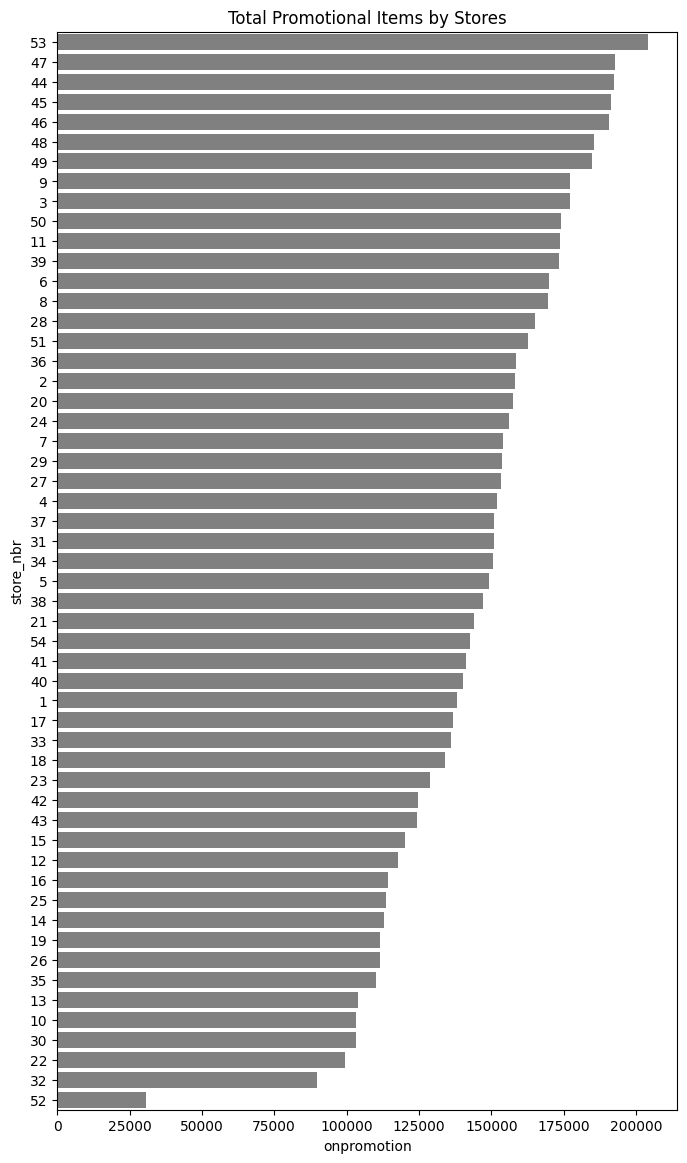

In [59]:
fig, ax = plt.subplots(figsize = (8,14))
sns.barplot(data=promotion_stores_df.to_pandas(), x='onpromotion', y = 'store_nbr', color='grey', ax=ax)
ax.set_title('Total Promotional Items by Stores')
plt.show();


### The Store Inactivity Summary classifies stores based on their operational status:
1. Stores that experienced a period of inactivity after opening: These stores were operational at some point but later experienced a shutdown or period of inactivity. - **inoperational_months**
2. Stores that opened after January 2013: These stores began operating sometime after January 2013. - **delayed_opening_months**




#### Stores that experienced a period of inactivity after opening: These stores were operational at some point but later experienced a shutdown or period of inactivity.

In [60]:
# Filter rows where the sales are greater than zero for each store to find opening dates
store_opening_dates = train_df.filter(pl.col('sales')>0).group_by('store_nbr', maintain_order=True).agg(pl.col('date').min())
store_opening_dates = store_opening_dates.with_columns(pl.col('date').dt.month().cast(pl.Int32).alias('opening_month'))
store_opening_dates = store_opening_dates.with_columns(pl.col('date').dt.year().alias('opening_year'))

# Group the data by 'store_nbr' and monthly 'date', then sum the 'sales'
store_ct_df = train_df.group_by(['store_nbr', pl.col('month'), pl.col('year')]).agg(pl.col('sales').sum())
store_ct_df = store_ct_df.with_columns(pl.date(pl.col('year'), pl.col('month'), 1).alias('date'))
# Find the inoperational months for each store
inoperational_months_df = store_ct_df.filter(pl.col('sales')==0).group_by('store_nbr', maintain_order=True).agg(pl.col('date').count().alias('inoperational_months'))
# Merge the results
store_summary_df = store_opening_dates.join(inoperational_months_df, on='store_nbr')

# Calculate the delayed_opening_months
store_summary_df = store_summary_df.with_columns(delayed_opening_months=abs(((2013 - pl.col('opening_year')) * 12) + (1 - pl.col('opening_month'))))

print(store_summary_df)

shape: (12, 6)
┌───────────┬────────────┬───────────────┬──────────────┬──────────────────────┬────────────────────────┐
│ store_nbr ┆ date       ┆ opening_month ┆ opening_year ┆ inoperational_months ┆ delayed_opening_months │
│ ---       ┆ ---        ┆ ---           ┆ ---          ┆ ---                  ┆ ---                    │
│ str       ┆ date       ┆ i32           ┆ i32          ┆ u32                  ┆ i32                    │
╞═══════════╪════════════╪═══════════════╪══════════════╪══════════════════════╪════════════════════════╡
│ 25        ┆ 2013-01-01 ┆ 1             ┆ 2013         ┆ 0                    ┆ 0                      │
│ 12        ┆ 2013-01-02 ┆ 1             ┆ 2013         ┆ 0                    ┆ 0                      │
│ 18        ┆ 2013-01-02 ┆ 1             ┆ 2013         ┆ 0                    ┆ 0                      │
│ 24        ┆ 2013-01-02 ┆ 1             ┆ 2013         ┆ 0                    ┆ 0                      │
│ 36        ┆ 2013-05-09 ┆ 5   

__**Delayed Opening Months:**__

The "Delayed Opening Months" represent the number of months from January 2013 until a store started reporting sales. This information is calculated for each store by finding the minimum date where sales were greater than zero. It indicates how long it took for a store to begin its operations and start recording sales data.

__**Inoperational Months:**__

On the other hand, "Inoperational Months" represent the count of months after a store became operational where it had zero sales. This information is obtained by grouping the data by store number and monthly date, then summing the sales for each group. The count reflects the number of months during which the store had no recorded sales.
From the analysis, we observed that most stores had the same number of inoperational months and delayed opening months. This suggests that these two metrics essentially provide the same information but are calculated using different approaches. However, for four specific stores (store numbers 12, 18, 24, and 25), there were differences between these metrics, indicating that these stores had periods of inactivity after they became operational.

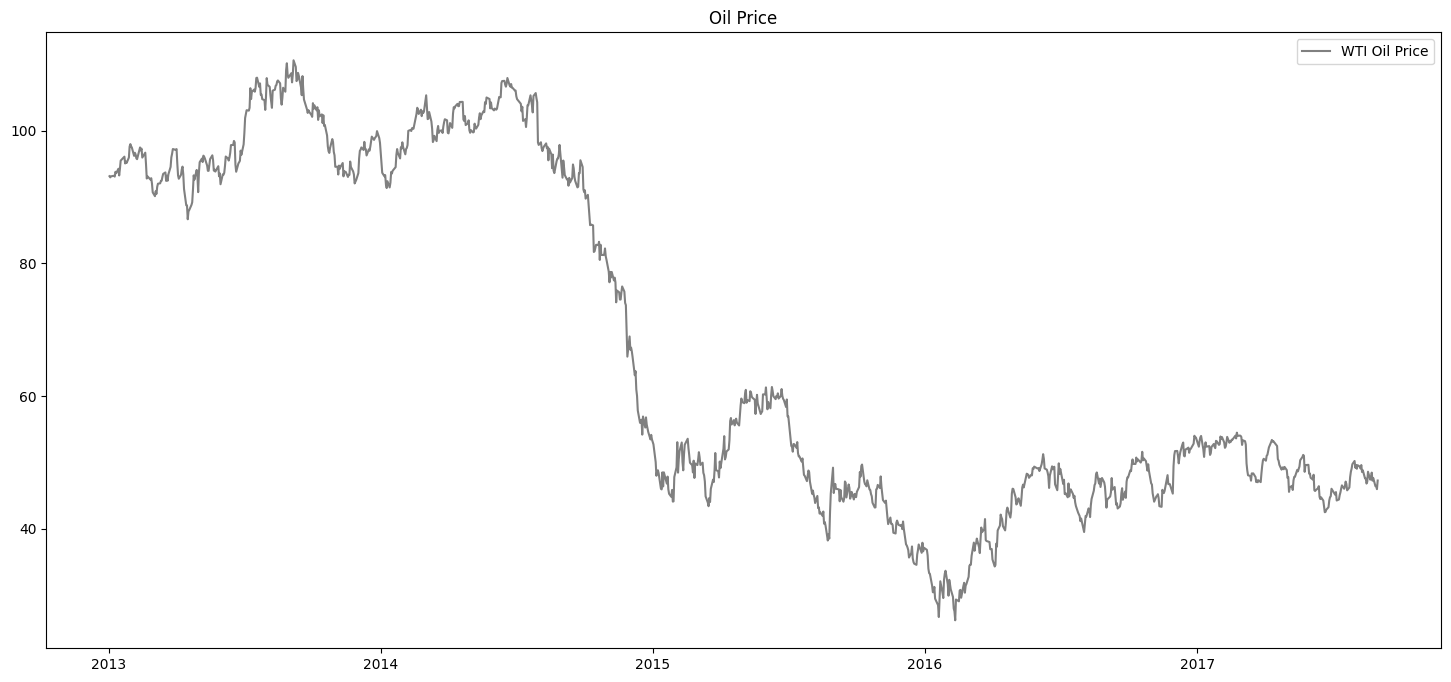

In [61]:
fig, ax = plt.subplots(figsize = (18,8))
sns.lineplot(data=oil_df, x='date', y='oil_price', color='grey', label='WTI Oil Price', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Oil Price')
plt.show();

### Importing Stores Data

In [62]:
stores_df = pl.read_csv('../data/input/stores.csv', dtypes={'store_nbr': str, 'cluster': str})
print(stores_df.head())

shape: (5, 5)
┌───────────┬───────────────┬────────────────────────────────┬──────┬─────────┐
│ store_nbr ┆ city          ┆ state                          ┆ type ┆ cluster │
│ ---       ┆ ---           ┆ ---                            ┆ ---  ┆ ---     │
│ str       ┆ str           ┆ str                            ┆ str  ┆ str     │
╞═══════════╪═══════════════╪════════════════════════════════╪══════╪═════════╡
│ 1         ┆ Quito         ┆ Pichincha                      ┆ D    ┆ 13      │
│ 2         ┆ Quito         ┆ Pichincha                      ┆ D    ┆ 13      │
│ 3         ┆ Quito         ┆ Pichincha                      ┆ D    ┆ 8       │
│ 4         ┆ Quito         ┆ Pichincha                      ┆ D    ┆ 9       │
│ 5         ┆ Santo Domingo ┆ Santo Domingo de los Tsachilas ┆ D    ┆ 4       │
└───────────┴───────────────┴────────────────────────────────┴──────┴─────────┘


### EDA on Stores Data

In [63]:
print(stores_df.select(pl.col('city').value_counts()))

shape: (22, 1)
┌─────────────────────┐
│ city                │
│ ---                 │
│ struct[2]           │
╞═════════════════════╡
│ {"Esmeraldas",1}    │
│ {"Daule",1}         │
│ {"Quevedo",1}       │
│ {"Loja",1}          │
│ {"Manta",2}         │
│ {"Latacunga",2}     │
│ {"Quito",18}        │
│ {"Cuenca",3}        │
│ …                   │
│ {"Guayaquil",8}     │
│ {"Machala",2}       │
│ {"Cayambe",1}       │
│ {"Playas",1}        │
│ {"Santo Domingo",3} │
│ {"Babahoyo",1}      │
│ {"El Carmen",1}     │
└─────────────────────┘


In [64]:
print(f"The number of cities with stores: {stores_df.select(pl.col('city').n_unique())}")

The number of cities with stores: shape: (1, 1)
┌──────┐
│ city │
│ ---  │
│ u32  │
╞══════╡
│ 22   │
└──────┘


In [65]:
# No of stores by State
print(stores_df.select(pl.col('state').value_counts()))

shape: (16, 1)
┌───────────────────────────────────┐
│ state                             │
│ ---                               │
│ struct[2]                         │
╞═══════════════════════════════════╡
│ {"Pastaza",1}                     │
│ {"Santa Elena",1}                 │
│ {"Chimborazo",1}                  │
│ {"Guayas",11}                     │
│ {"Manabi",3}                      │
│ {"Cotopaxi",2}                    │
│ {"Tungurahua",2}                  │
│ {"Azuay",3}                       │
│ …                                 │
│ {"Esmeraldas",1}                  │
│ {"Loja",1}                        │
│ {"Imbabura",1}                    │
│ {"Bolivar",1}                     │
│ {"Pichincha",19}                  │
│ {"Santo Domingo de los Tsachilas… │
│ {"El Oro",2}                      │
└───────────────────────────────────┘


In [66]:
print(f"The number of states with stores: {stores_df.select(pl.col('state').n_unique())}")

The number of states with stores: shape: (1, 1)
┌───────┐
│ state │
│ ---   │
│ u32   │
╞═══════╡
│ 16    │
└───────┘


In [67]:
# Count of stores based on city, state

print(stores_df.group_by(['state', 'city']).agg(count=pl.col('city').count()).sort('count', descending=True))

shape: (22, 3)
┌────────────────────────────────┬───────────────┬───────┐
│ state                          ┆ city          ┆ count │
│ ---                            ┆ ---           ┆ ---   │
│ str                            ┆ str           ┆ u32   │
╞════════════════════════════════╪═══════════════╪═══════╡
│ Pichincha                      ┆ Quito         ┆ 18    │
│ Guayas                         ┆ Guayaquil     ┆ 8     │
│ Santo Domingo de los Tsachilas ┆ Santo Domingo ┆ 3     │
│ Azuay                          ┆ Cuenca        ┆ 3     │
│ Manabi                         ┆ Manta         ┆ 2     │
│ El Oro                         ┆ Machala       ┆ 2     │
│ Cotopaxi                       ┆ Latacunga     ┆ 2     │
│ Tungurahua                     ┆ Ambato        ┆ 2     │
│ …                              ┆ …             ┆ …     │
│ Los Rios                       ┆ Babahoyo      ┆ 1     │
│ Manabi                         ┆ El Carmen     ┆ 1     │
│ Guayas                         ┆ Daule 

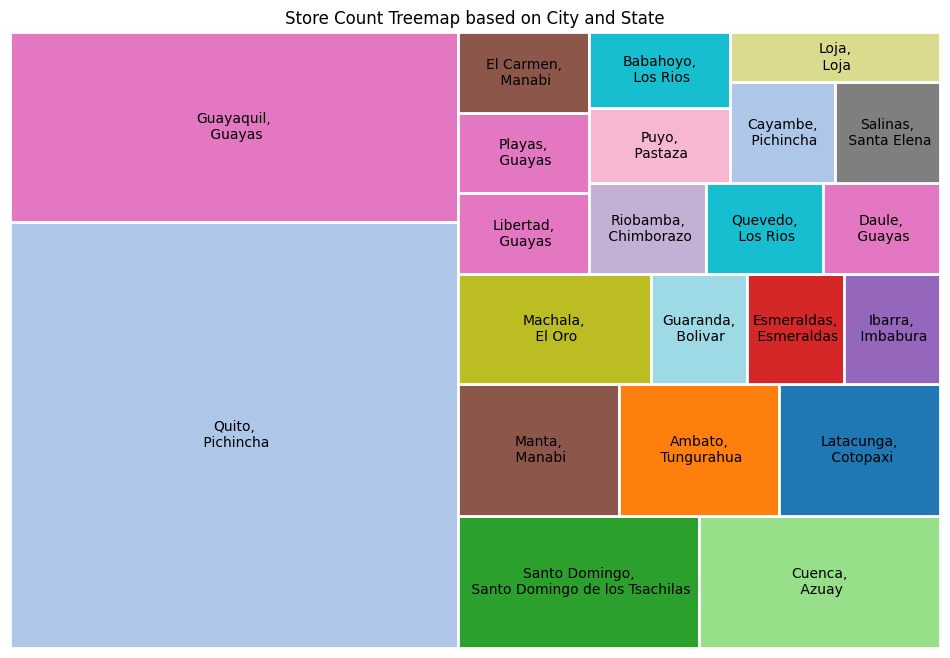

In [68]:
# Group the data by state and city and calculate the count of stores
store_counts= stores_df.group_by(['state', 'city']).agg(count=pl.col('city').count()).sort('count', descending=True)

# Create the treemap
plt.figure(figsize=(12, 8))

# Normalize counts based on the sum for each state
state_counts= store_counts.group_by('state').agg(count=pl.col('count').sum())

unique_states = store_counts.select(pl.col('state').unique()).to_series()
cmap = plt.get_cmap('tab20', len(unique_states))

# Plot the treemap and color based on states
color_list = [cmap(unique_states.to_list().index(state)) for state in store_counts['state']]
squarify.plot(sizes=store_counts['count'], label=store_counts['city'] + ',\n ' + store_counts['state'],
              color=color_list, edgecolor='white', linewidth=2)

# Add title and axis labels
plt.title('Store Count Treemap based on City and State')
plt.axis('off')

plt.show();

In [69]:
# heatmap_data =heatmap_data.with_columns(pl.exclude('state').cast(pl.Int32))
# (heatmap_data.to_pandas())

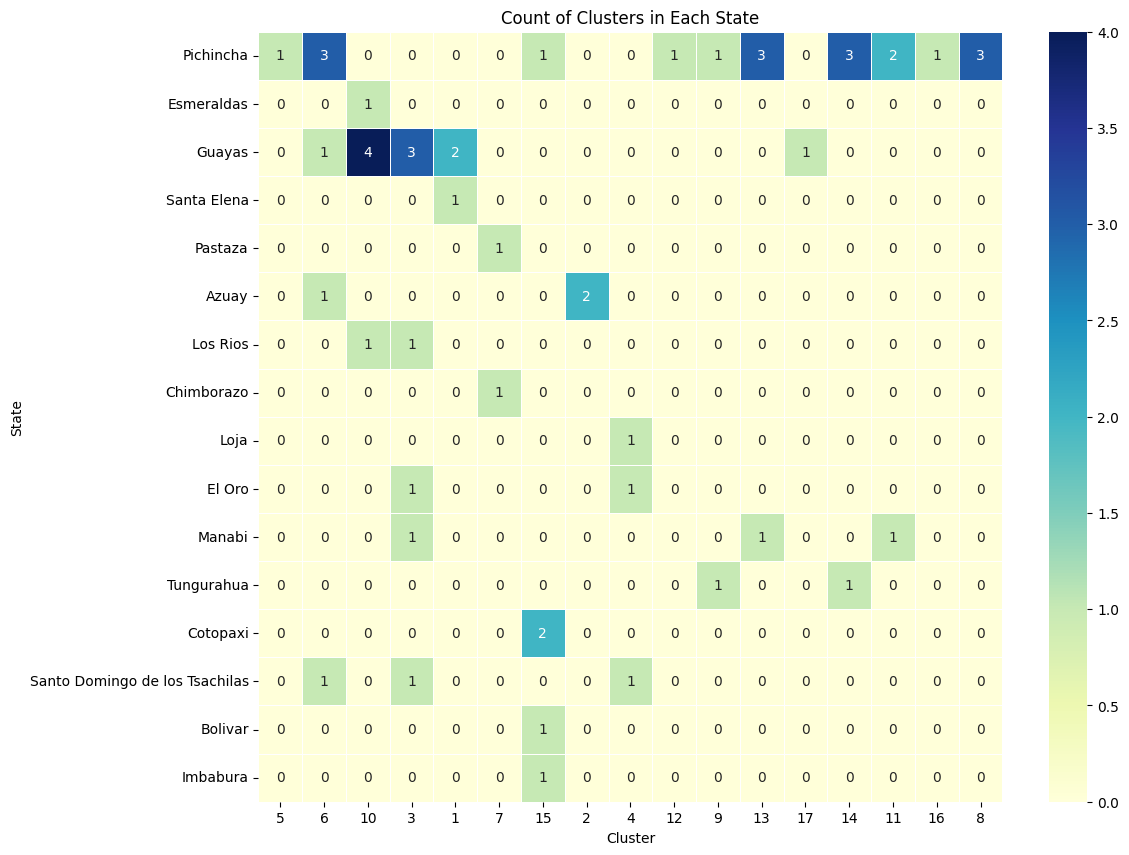

In [70]:
# Get the count of stores in each state and cluster
store_count_by_state_cluster = stores_df.group_by(['state', 'cluster']).agg(count=pl.col('cluster').count())

# Pivot the DataFrame to create a matrix of counts for each state and cluster
heatmap_data = store_count_by_state_cluster.pivot(index='state', columns='cluster', values='count', aggregate_function=None).fill_null(0)
heatmap_data =heatmap_data.with_columns(pl.exclude('state').cast(pl.Int32))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Use seaborn's heatmap to plot the data
sns.heatmap(heatmap_data.to_pandas().set_index('state'), cmap='YlGnBu', annot=True, fmt='g', linewidths=0.5, ax=ax)

ax.set_xlabel('Cluster')
ax.set_ylabel('State')
ax.set_title('Count of Clusters in Each State')

plt.show();

In [71]:
cluster_counts = stores_df.select(pl.col('cluster').value_counts())
cluster_counts = cluster_counts.unnest(columns='cluster')
print(cluster_counts)

shape: (17, 2)
┌─────────┬───────┐
│ cluster ┆ count │
│ ---     ┆ ---   │
│ str     ┆ u32   │
╞═════════╪═══════╡
│ 14      ┆ 4     │
│ 11      ┆ 3     │
│ 1       ┆ 3     │
│ 4       ┆ 3     │
│ 6       ┆ 6     │
│ 9       ┆ 2     │
│ 13      ┆ 4     │
│ 5       ┆ 1     │
│ …       ┆ …     │
│ 17      ┆ 1     │
│ 12      ┆ 1     │
│ 15      ┆ 5     │
│ 16      ┆ 1     │
│ 2       ┆ 2     │
│ 8       ┆ 3     │
│ 3       ┆ 7     │
└─────────┴───────┘


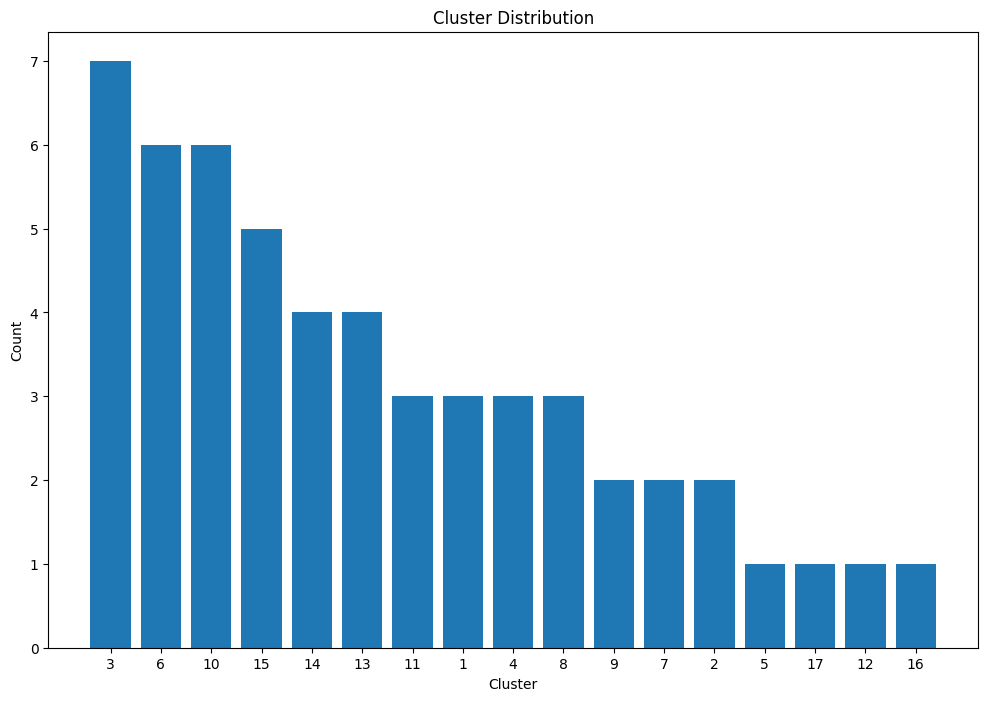

In [72]:
cluster_counts = cluster_counts.sort('count', descending=True)
cluster_counts=cluster_counts.to_pandas()
cluster_counts.set_index('cluster', inplace=True)
# Step 2: Create a bar plot
plt.figure(figsize=(12, 8))
plt.bar(cluster_counts.index, cluster_counts['count'].to_list())
# plt.bar(cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.xticks(cluster_counts.index, rotation=0)
plt.show()


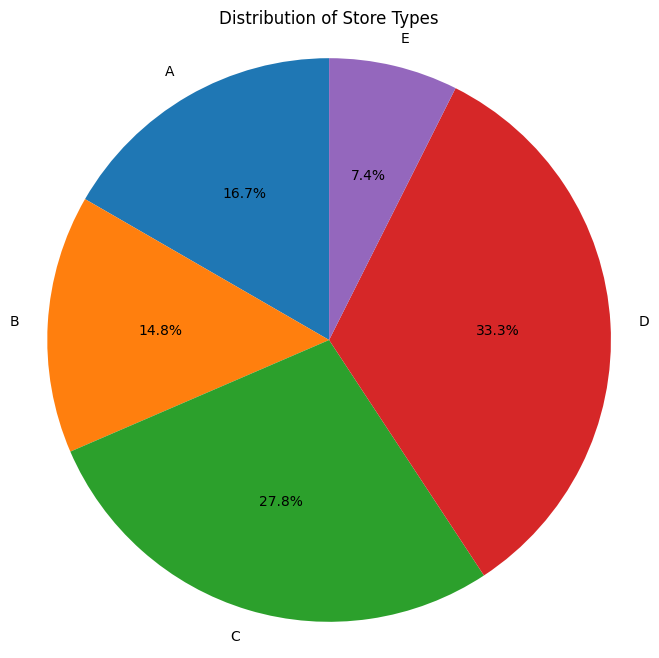

In [73]:
plt.figure(figsize=(8, 8))
store_type_counts = stores_df.select(pl.col('type').value_counts()).unnest('type').sort('type')
plt.pie(store_type_counts.select(pl.col('count')).to_series(), labels=store_type_counts.select(pl.col('type')).to_series(), autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Store Types')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.show()

In [74]:
country_shapefile_path = '../data/input/ecu_adm_inec_20190724_shp/ecu_admbnda_adm0_inec_20190724.shp'
states_shapefile_path = '../data/input/ecu_adm_inec_20190724_shp/ecu_admbnda_adm1_inec_20190724.shp'
cities_shapefile_path = '../data/input/ecu_adm_inec_20190724_shp/ecu_admbnda_adm2_inec_20190724.shp'

country_gdf = gpd.read_file(country_shapefile_path)
states_gdf = gpd.read_file(states_shapefile_path)
cities_gdf = gpd.read_file(cities_shapefile_path)

# states_gdf = pl.from_pandas(states_gdf)
states_gdf.head()

,Shape_Leng,Shape_Area,ADM1_ES,ADM1_PCODE,ADM1_REF,ADM1ALT1ES,ADM1ALT2ES,ADM0_EN,ADM0_ES,ADM0_PCODE,date,validOn,validTo,geometry
0,6.129025,0.677123,Azuay,EC01,None,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-79.39734 -2.49713, -79.39698 -2.497..."
1,4.084794,0.320511,Bolivar,EC02,None,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-79.10549 -1.15052, -79.10508 -1.150..."
2,3.603253,0.255799,Cañar,EC03,Canar,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-79.13561 -2.21507, -79.13552 -2.215..."
3,4.266990,0.306549,Carchi,EC04,None,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-78.49292 1.19558, -78.49316 1.19529..."
4,4.693803,0.528003,Chimborazo,EC06,None,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-78.77084 -1.43063, -78.77033 -1.430..."


In [75]:
country_gdf

,Shape_Leng,Shape_Area,ADM0_EN,ADM0_ES,ADM0_PCODE,ADM0_REF,ADM0ALT1EN,ADM0ALT2EN,ADM0ALT1ES,ADM0ALT2ES,date,validOn,validTo,geometry
0,82.510556,20.787251,Ecuador,Ecuador (el),EC,None,None,None,None,None,2018-12-17,2019-07-24,None,"MULTIPOLYGON (((-80.20645 -3.43884, -80.20748 ..."


In [76]:
cities_gdf.head()

,Shape_Leng,Shape_Area,ADM2_ES,ADM2_PCODE,ADM2_REF,ADM2ALT1ES,ADM2ALT2ES,ADM1_ES,ADM1_PCODE,ADM0_EN,ADM0_ES,ADM0_PCODE,date,validOn,validTo,geometry
0,1.388732,0.042720,24 de Mayo,EC1316,None,None,None,Manabi,EC13,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-80.43062 -1.21291, -80.43030 -1.212..."
1,7.096122,0.906912,Aguarico,EC2202,None,None,None,Orellana,EC22,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-75.85209 -0.40932, -75.85192 -0.410..."
2,2.777711,0.134697,Alausi,EC0602,None,None,None,Chimborazo,EC06,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-79.00231 -2.08336, -79.00206 -2.083..."
3,0.740157,0.017774,Alfredo Baquerizo Moreno,EC0902,None,None,None,Guayas,EC09,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-79.45505 -1.91723, -79.45497 -1.917..."
4,1.547719,0.082689,Ambato,EC1801,None,None,None,Tungurahua,EC18,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-78.61249 -1.10990, -78.61191 -1.110..."


In [77]:
states_gdf.head()

,Shape_Leng,Shape_Area,ADM1_ES,ADM1_PCODE,ADM1_REF,ADM1ALT1ES,ADM1ALT2ES,ADM0_EN,ADM0_ES,ADM0_PCODE,date,validOn,validTo,geometry
0,6.129025,0.677123,Azuay,EC01,None,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-79.39734 -2.49713, -79.39698 -2.497..."
1,4.084794,0.320511,Bolivar,EC02,None,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-79.10549 -1.15052, -79.10508 -1.150..."
2,3.603253,0.255799,Cañar,EC03,Canar,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-79.13561 -2.21507, -79.13552 -2.215..."
3,4.266990,0.306549,Carchi,EC04,None,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-78.49292 1.19558, -78.49316 1.19529..."
4,4.693803,0.528003,Chimborazo,EC06,None,None,None,Ecuador,Ecuador (el),EC,2018-12-17,2019-07-24,None,"POLYGON ((-78.77084 -1.43063, -78.77033 -1.430..."


In [78]:
population_df = pl.read_csv('../data/input/ecu_adm_inec_20190724_shp/ecu_admpop_adm1_2020.csv', columns=range(8))
print(population_df)

shape: (25, 8)
┌─────────┬────────────┬────────────────────┬────────────┬──────┬────────┬────────┬────────┐
│ ADM0_EN ┆ ADM0_PCODE ┆ ADM1_EN            ┆ ADM1_PCODE ┆ Year ┆ F_TL   ┆ M_TL   ┆ T_TL   │
│ ---     ┆ ---        ┆ ---                ┆ ---        ┆ ---  ┆ ---    ┆ ---    ┆ ---    │
│ str     ┆ str        ┆ str                ┆ str        ┆ i64  ┆ i64    ┆ i64    ┆ i64    │
╞═════════╪════════════╪════════════════════╪════════════╪══════╪════════╪════════╪════════╡
│ Ecuador ┆ EC         ┆ AZUAY              ┆ EC01       ┆ 2020 ┆ 459159 ┆ 422235 ┆ 881394 │
│ Ecuador ┆ EC         ┆ BOLIVAR            ┆ EC02       ┆ 2020 ┆ 107504 ┆ 102429 ┆ 209933 │
│ Ecuador ┆ EC         ┆ CAÑAR              ┆ EC03       ┆ 2020 ┆ 147041 ┆ 134355 ┆ 281396 │
│ Ecuador ┆ EC         ┆ CARCHI             ┆ EC04       ┆ 2020 ┆ 94102  ┆ 92767  ┆ 186869 │
│ Ecuador ┆ EC         ┆ COTOPAXI           ┆ EC05       ┆ 2020 ┆ 251010 ┆ 237706 ┆ 488716 │
│ Ecuador ┆ EC         ┆ CHIMBORAZO         ┆ EC06     

In [79]:
population_df = population_df.with_columns(total_population=pl.col('F_TL')+pl.col('M_TL')+pl.col('T_TL'))
print(population_df)

shape: (25, 9)
┌─────────┬────────────┬────────────────────┬────────────┬──────┬────────┬────────┬────────┬──────────────────┐
│ ADM0_EN ┆ ADM0_PCODE ┆ ADM1_EN            ┆ ADM1_PCODE ┆ Year ┆ F_TL   ┆ M_TL   ┆ T_TL   ┆ total_population │
│ ---     ┆ ---        ┆ ---                ┆ ---        ┆ ---  ┆ ---    ┆ ---    ┆ ---    ┆ ---              │
│ str     ┆ str        ┆ str                ┆ str        ┆ i64  ┆ i64    ┆ i64    ┆ i64    ┆ i64              │
╞═════════╪════════════╪════════════════════╪════════════╪══════╪════════╪════════╪════════╪══════════════════╡
│ Ecuador ┆ EC         ┆ AZUAY              ┆ EC01       ┆ 2020 ┆ 459159 ┆ 422235 ┆ 881394 ┆ 1762788          │
│ Ecuador ┆ EC         ┆ BOLIVAR            ┆ EC02       ┆ 2020 ┆ 107504 ┆ 102429 ┆ 209933 ┆ 419866           │
│ Ecuador ┆ EC         ┆ CAÑAR              ┆ EC03       ┆ 2020 ┆ 147041 ┆ 134355 ┆ 281396 ┆ 562792           │
│ Ecuador ┆ EC         ┆ CARCHI             ┆ EC04       ┆ 2020 ┆ 94102  ┆ 92767  ┆ 18686

In [80]:
stores_df = stores_df.to_pandas()
store_sales = store_sales.to_pandas()
population_df = population_df.to_pandas()

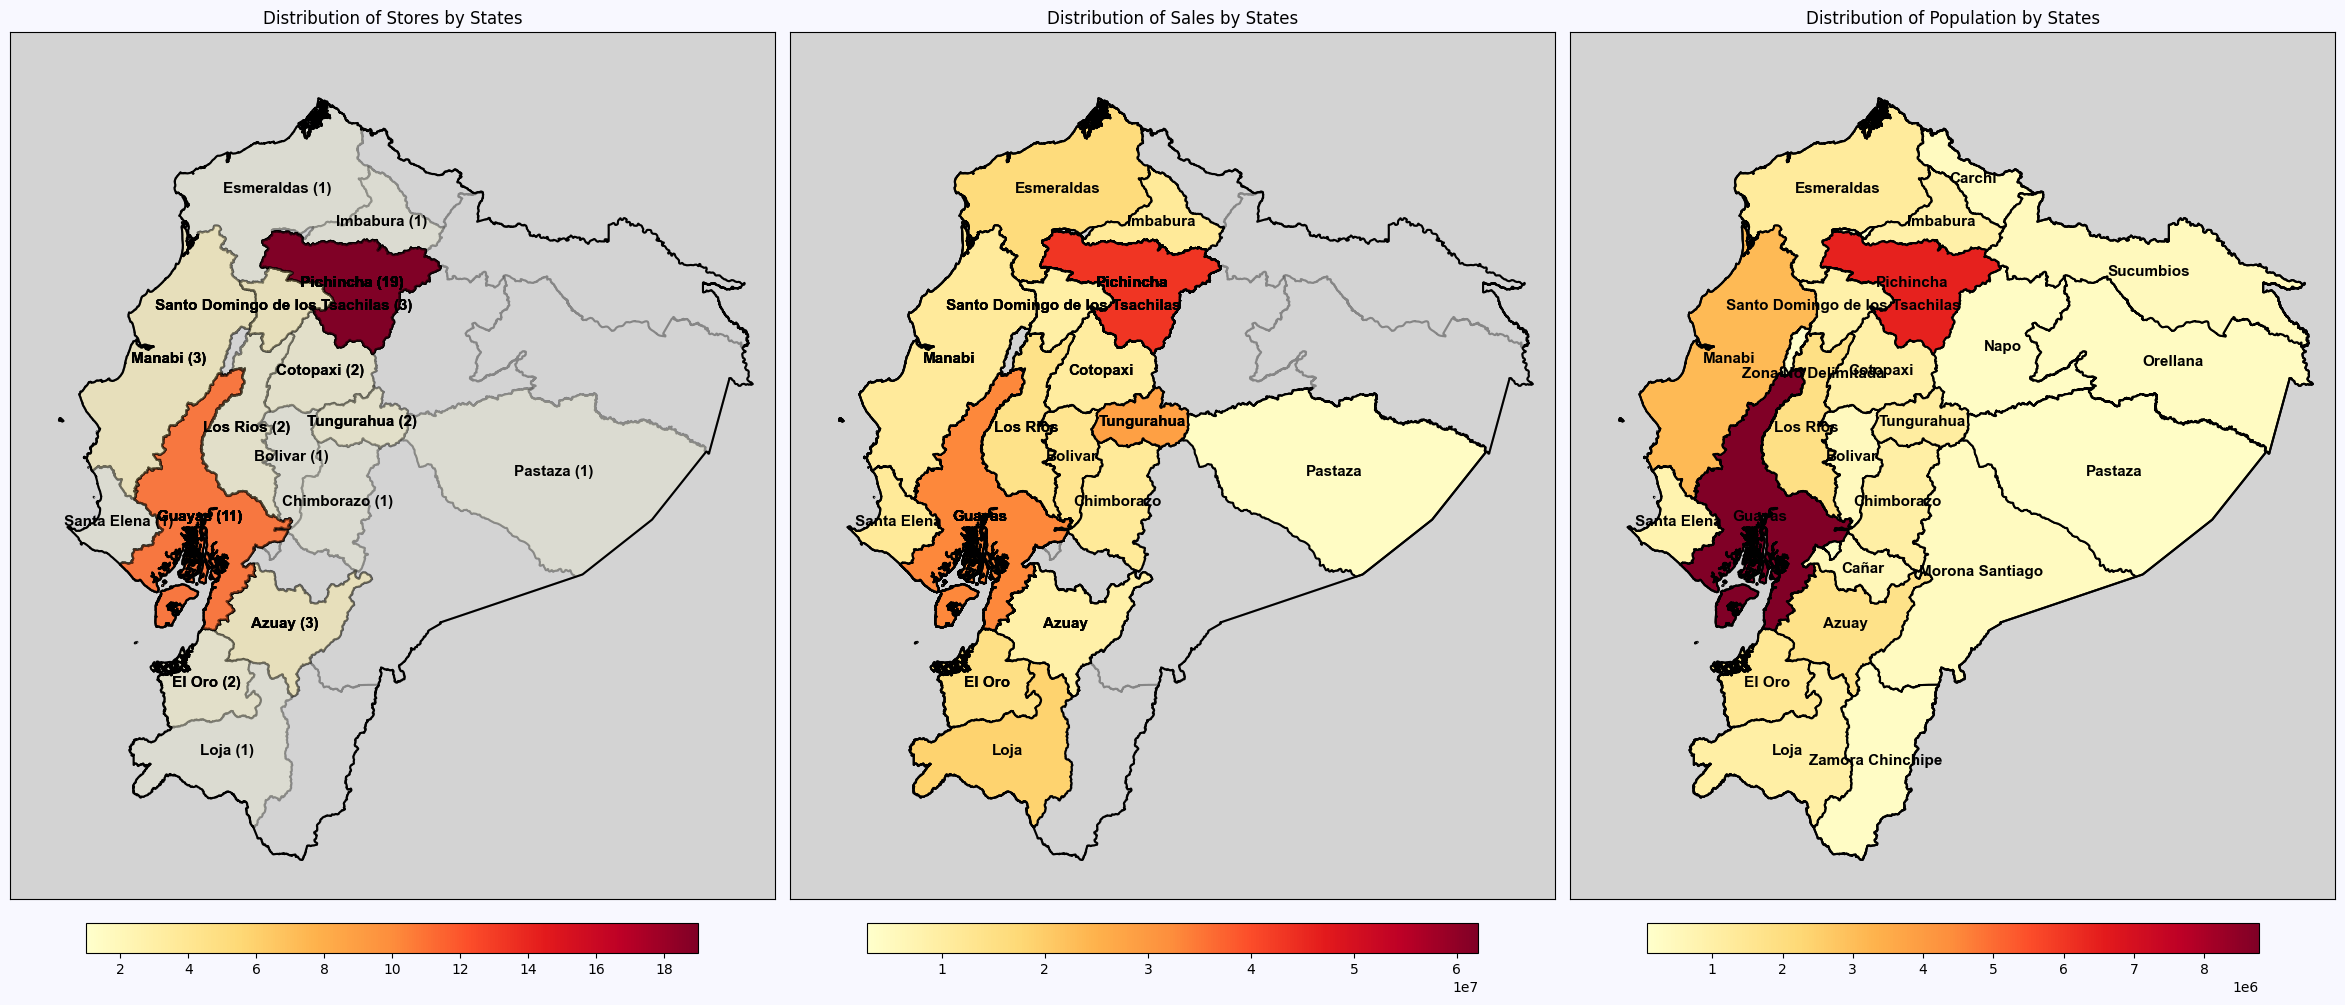

In [81]:


# Create the plot
fig, (ax, ax1, ax2) = plt.subplots(ncols = 3, figsize=(30, 15), sharey=True, gridspec_kw={'hspace': 0.0, 'wspace': 0.02})
# Set the background color for the entire figure
fig.set_facecolor('ghostwhite')
ax.set_facecolor('lightgray')
ax1.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')

shrink=0.8
pad=0.02
cmap = 'YlOrRd'
# Adjust the font properties for the text in the second plot
font_dict = {
    'fontname': 'Arial',  # Change to the desired font family (e.g., 'serif', 'sans-serif', etc.)
    'fontsize': 11,         # Change to the desired font size
    'fontweight': 'bold',    # Change to 'normal' for regular weight, 'bold' for bold weight
    'color': 'black' # Change to the desired font color
}

# Plot the country boundaries
country_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Merge states_gdf with stores_df to determine which states have stores (inner merge)
states_with_stores_gdf = states_gdf.merge(stores_df, left_on='ADM1_ES', right_on='state', how='inner')

# Get the count of stores in each state
store_count_by_state = stores_df['state'].value_counts()

# Plot the states and fill them with color intensity based on the store count

norm = mcolors.Normalize(vmin=store_count_by_state.min(), vmax=store_count_by_state.max())
states_with_stores_gdf.plot(ax=ax, cmap=cmap, edgecolor='black', linewidth=1.5, alpha=0.2,
                            column=states_with_stores_gdf['state'].map(store_count_by_state), legend=True, norm=norm, legend_kwds={
                            "location":"bottom",
                            "shrink":shrink,
                            "pad":pad})

# Get the states without stores (not included in the inner merge)
states_without_stores_gdf = states_gdf[~states_gdf['ADM1_ES'].isin(states_with_stores_gdf['ADM1_ES'])]

# Plot the states without stores and leave them unfilled (black outline)
states_without_stores_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5, alpha=0.2,)

# Add labels to the states with stores using centroids
for idx, row in states_with_stores_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, f"{row['ADM1_ES']} ({store_count_by_state.get(row['state'], 0)})", ha='center', va='center', fontdict=font_dict)



# Step 1: Merge store_sales with stores_df based on 'store_nbr'
stores_with_sales = stores_df.merge(store_sales[['store_nbr', 'sales']], on='store_nbr', how='left')

# Step 2: Merge stores_with_sales with states_gdf based on 'state'
states_with_sales_gdf = states_gdf.merge(stores_with_sales, left_on='ADM1_ES', right_on='state', how='inner')

# Step 3: Group by state and calculate total sales for each state
sales_by_state = states_with_sales_gdf.groupby('ADM1_ES')['sales'].sum().reset_index()


# Plot the country boundaries
country_gdf.boundary.plot(ax=ax1, color='black', linewidth=1.5)

# Plot the states and color them by total sales
states_with_sales_gdf.plot(ax=ax1, cmap=cmap, edgecolor='black', linewidth=1.5,
                           column=states_with_sales_gdf['sales'], legend=True,  legend_kwds={
                            "location":"bottom",
                            "shrink":shrink,
                            "pad":pad})

# Plot the states without stores and leave them unfilled (black outline)
states_without_stores_gdf.plot(ax=ax1, color='none', edgecolor='black', linewidth=1.5, alpha=0.2,)

# # Add labels to the states using centroids
for idx, row in states_with_sales_gdf.iterrows():
    centroid = row.geometry.centroid
    ax1.text(centroid.x, centroid.y, f"{row['ADM1_ES']}", ha='center', va='center', fontdict=font_dict)

states_population_gdf = states_gdf.merge(population_df[['ADM1_EN', 'total_population', 'ADM1_PCODE']], left_on='ADM1_PCODE', right_on='ADM1_PCODE', how='inner')

# Plot the country boundaries
country_gdf.boundary.plot(ax=ax2, color='black', linewidth=1.5)

# Plot the states and color them by total sales
states_population_gdf.plot(ax=ax2, cmap=cmap, edgecolor='black', linewidth=1.5,
                           column=states_population_gdf['total_population'], legend=True,  legend_kwds={
                            "location":"bottom",
                            "shrink":shrink,
                            "pad":pad})

# # Add labels to the states using centroids
for idx, row in states_population_gdf.iterrows():
    if row['ADM1_EN'] != 'GALAPAGOS':
        centroid = row.geometry.centroid
        ax2.text(centroid.x, centroid.y, f"{row['ADM1_ES']}", ha='center', va='center', fontdict=font_dict)

ax.set_title('Distribution of Stores by States')
ax.set_xlim(-81.5, -75) 

ax1.set_title('Distribution of Sales by States')
ax1.set_xlim(-81.5, -75)  # Adjust the x-axis limit to fit the left side of the map

ax2.set_title('Distribution of Population by States')
ax2.set_xlim(-81.5, -75)  # Adjust the x-axis limit to fit the left side of the map

ax.set_xticks([])
ax1.set_xticks([])
ax.set_yticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

ax.set_xticklabels([])
ax1.set_xticklabels([])
ax.set_yticklabels([])
ax1.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax.set_xlabel('')
ax1.set_xlabel('')
ax.set_ylabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.show();


### Importing Holidays_events

**holidays_events.csv**
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is **transferred** officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 
  - In the database these holidays can be found as the next entry following the type=Holiday and transferred=True. For eg Row 19 and Row 20
<br><br>  

- Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [82]:
holiday_events_df = pl.read_csv('../data/input/holidays_events.csv', try_parse_dates=True)
# print(holiday_events_df)

In [83]:
holiday_events_df = holiday_events_df.with_columns(pl.col('date').str.strptime(pl.Date, '%m/%d/%y'))

holiday_events_df = holiday_events_df.with_columns(
    dayofweek = pl.col('date').dt.weekday().cast(pl.Int8).map_elements(
        lambda x: day_names[x-1], 
        return_dtype=pl.Utf8
    )
)
print(holiday_events_df)

shape: (350, 7)
┌────────────┬────────────┬──────────┬─────────────┬───────────────────────────────┬─────────────┬───────────┐
│ date       ┆ type       ┆ locale   ┆ locale_name ┆ description                   ┆ transferred ┆ dayofweek │
│ ---        ┆ ---        ┆ ---      ┆ ---         ┆ ---                           ┆ ---         ┆ ---       │
│ date       ┆ str        ┆ str      ┆ str         ┆ str                           ┆ bool        ┆ str       │
╞════════════╪════════════╪══════════╪═════════════╪═══════════════════════════════╪═════════════╪═══════════╡
│ 2012-03-02 ┆ Holiday    ┆ Local    ┆ Manta       ┆ Fundacion de Manta            ┆ false       ┆ Friday    │
│ 2012-04-01 ┆ Holiday    ┆ Regional ┆ Cotopaxi    ┆ Provincializacion de Cotopaxi ┆ false       ┆ Sunday    │
│ 2012-04-12 ┆ Holiday    ┆ Local    ┆ Cuenca      ┆ Fundacion de Cuenca           ┆ false       ┆ Thursday  │
│ 2012-04-14 ┆ Holiday    ┆ Local    ┆ Libertad    ┆ Cantonizacion de Libertad     ┆ false      

#### Transferred Holidays and their corresponding Actual Holidays

In [84]:
print(holiday_events_df.filter(pl.col('transferred')==True))

shape: (12, 7)
┌────────────┬─────────┬──────────┬─────────────┬───────────────────────────────┬─────────────┬───────────┐
│ date       ┆ type    ┆ locale   ┆ locale_name ┆ description                   ┆ transferred ┆ dayofweek │
│ ---        ┆ ---     ┆ ---      ┆ ---         ┆ ---                           ┆ ---         ┆ ---       │
│ date       ┆ str     ┆ str      ┆ str         ┆ str                           ┆ bool        ┆ str       │
╞════════════╪═════════╪══════════╪═════════════╪═══════════════════════════════╪═════════════╪═══════════╡
│ 2012-10-09 ┆ Holiday ┆ National ┆ Ecuador     ┆ Independencia de Guayaquil    ┆ true        ┆ Tuesday   │
│ 2013-10-09 ┆ Holiday ┆ National ┆ Ecuador     ┆ Independencia de Guayaquil    ┆ true        ┆ Wednesday │
│ 2014-10-09 ┆ Holiday ┆ National ┆ Ecuador     ┆ Independencia de Guayaquil    ┆ true        ┆ Thursday  │
│ 2016-05-24 ┆ Holiday ┆ National ┆ Ecuador     ┆ Batalla de Pichincha          ┆ true        ┆ Tuesday   │
│ 2016-07-25 

#### Bridge Holidays and their corresponding Working days

In [85]:
print(holiday_events_df.filter(pl.col('type')=='Bridge'))

shape: (5, 7)
┌────────────┬────────┬──────────┬─────────────┬───────────────────────────┬─────────────┬───────────┐
│ date       ┆ type   ┆ locale   ┆ locale_name ┆ description               ┆ transferred ┆ dayofweek │
│ ---        ┆ ---    ┆ ---      ┆ ---         ┆ ---                       ┆ ---         ┆ ---       │
│ date       ┆ str    ┆ str      ┆ str         ┆ str                       ┆ bool        ┆ str       │
╞════════════╪════════╪══════════╪═════════════╪═══════════════════════════╪═════════════╪═══════════╡
│ 2012-12-24 ┆ Bridge ┆ National ┆ Ecuador     ┆ Puente Navidad            ┆ false       ┆ Monday    │
│ 2012-12-31 ┆ Bridge ┆ National ┆ Ecuador     ┆ Puente Primer dia del ano ┆ false       ┆ Monday    │
│ 2014-12-26 ┆ Bridge ┆ National ┆ Ecuador     ┆ Puente Navidad            ┆ false       ┆ Friday    │
│ 2015-01-02 ┆ Bridge ┆ National ┆ Ecuador     ┆ Puente Primer dia del ano ┆ false       ┆ Friday    │
│ 2016-11-04 ┆ Bridge ┆ National ┆ Ecuador     ┆ Puente Dia

In [86]:
print(holiday_events_df.filter((pl.col('type') == 'Work Day') & ((pl.col('dayofweek') == 'Saturday') | (pl.col('dayofweek') == 'Sunday'))))

shape: (5, 7)
┌────────────┬──────────┬──────────┬─────────────┬───────────────────────────────────┬─────────────┬───────────┐
│ date       ┆ type     ┆ locale   ┆ locale_name ┆ description                       ┆ transferred ┆ dayofweek │
│ ---        ┆ ---      ┆ ---      ┆ ---         ┆ ---                               ┆ ---         ┆ ---       │
│ date       ┆ str      ┆ str      ┆ str         ┆ str                               ┆ bool        ┆ str       │
╞════════════╪══════════╪══════════╪═════════════╪═══════════════════════════════════╪═════════════╪═══════════╡
│ 2013-01-05 ┆ Work Day ┆ National ┆ Ecuador     ┆ Recupero puente Navidad           ┆ false       ┆ Saturday  │
│ 2013-01-12 ┆ Work Day ┆ National ┆ Ecuador     ┆ Recupero puente primer dia del a… ┆ false       ┆ Saturday  │
│ 2014-12-20 ┆ Work Day ┆ National ┆ Ecuador     ┆ Recupero Puente Navidad           ┆ false       ┆ Saturday  │
│ 2015-01-10 ┆ Work Day ┆ National ┆ Ecuador     ┆ Recupero Puente Primer dia del 

#### Additional Holidays

In [87]:
print(holiday_events_df.filter(pl.col('type')=='Additional'))

shape: (51, 7)
┌────────────┬────────────┬──────────┬─────────────┬────────────────────────┬─────────────┬───────────┐
│ date       ┆ type       ┆ locale   ┆ locale_name ┆ description            ┆ transferred ┆ dayofweek │
│ ---        ┆ ---        ┆ ---      ┆ ---         ┆ ---                    ┆ ---         ┆ ---       │
│ date       ┆ str        ┆ str      ┆ str         ┆ str                    ┆ bool        ┆ str       │
╞════════════╪════════════╪══════════╪═════════════╪════════════════════════╪═════════════╪═══════════╡
│ 2012-12-05 ┆ Additional ┆ Local    ┆ Quito       ┆ Fundacion de Quito-1   ┆ false       ┆ Wednesday │
│ 2012-12-21 ┆ Additional ┆ National ┆ Ecuador     ┆ Navidad-4              ┆ false       ┆ Friday    │
│ 2012-12-22 ┆ Additional ┆ National ┆ Ecuador     ┆ Navidad-3              ┆ false       ┆ Saturday  │
│ 2012-12-23 ┆ Additional ┆ National ┆ Ecuador     ┆ Navidad-2              ┆ false       ┆ Sunday    │
│ 2012-12-24 ┆ Additional ┆ National ┆ Ecuador   

Based on the description of holiday_events, we need to figure out if a particular day of the week was a working day or not.

There are 3 types of adjustments that will be needed <br>
1. Transferred Holidays- These are actually working day. To find the corresponding day when the holiday was actually celebrated, filter out rows which are of type=Transfer<br><br>
2. Bridge Holidays - type=Bridge are non-working days. To find the corresponding working day (make up day for the bridge holiday) filter rows by type=Workday which falls on a weekend. As a side note, description column will have<br>
   "recupero" prefixed to the original holiday description. For eg Puente Navidad	-> Recupero Puente Navidad	<br><br>
3. Additional Holidays are just non-working days. They correspond to type-Additional

In [88]:
pl.Config.set_tbl_width_chars(width= 200)

polars.config.Config

In [89]:
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekend = ['Saturday', 'Sunday']
holiday_events_df = holiday_events_df.with_columns(
                                                    pl.when(pl.col('dayofweek')
                                                    .is_in(weekday))
                                                    .then(pl.lit('Yes'))
                                                    .otherwise(pl.lit('No')).alias('working_day'))
print(holiday_events_df)

shape: (350, 8)
┌────────────┬────────────┬──────────┬─────────────┬───────────────────────────────┬─────────────┬───────────┬─────────────┐
│ date       ┆ type       ┆ locale   ┆ locale_name ┆ description                   ┆ transferred ┆ dayofweek ┆ working_day │
│ ---        ┆ ---        ┆ ---      ┆ ---         ┆ ---                           ┆ ---         ┆ ---       ┆ ---         │
│ date       ┆ str        ┆ str      ┆ str         ┆ str                           ┆ bool        ┆ str       ┆ str         │
╞════════════╪════════════╪══════════╪═════════════╪═══════════════════════════════╪═════════════╪═══════════╪═════════════╡
│ 2012-03-02 ┆ Holiday    ┆ Local    ┆ Manta       ┆ Fundacion de Manta            ┆ false       ┆ Friday    ┆ Yes         │
│ 2012-04-01 ┆ Holiday    ┆ Regional ┆ Cotopaxi    ┆ Provincializacion de Cotopaxi ┆ false       ┆ Sunday    ┆ No          │
│ 2012-04-12 ┆ Holiday    ┆ Local    ┆ Cuenca      ┆ Fundacion de Cuenca           ┆ false       ┆ Thursday  

In [90]:
# Adjusting Transferred Holidays
holiday_events_df = holiday_events_df.with_columns(
    working_day=pl.when(pl.col('transferred')==True)
    .then(pl.lit('Yes'))
    .when(pl.col('type')=='Transfer')
    .then(pl.lit('No'))
    .otherwise(pl.col('working_day'))
)

In [91]:
# Adjusting Bridge Holidays

holiday_events_df = (holiday_events_df.with_columns(
    working_day = pl.when(pl.col('type')=='Bridge')
    .then(pl.lit('No'))
    .when((pl.col('type')=='Work Day') & 
    ((pl.col('dayofweek') == 'Saturday') | (pl.col('dayofweek') == 'Sunday')))
    .then(pl.lit('Yes'))
    .otherwise(pl.col('working_day'))
    ))

In [92]:
# Adjusting for Additional Holidays
holiday_events_df = holiday_events_df.with_columns(
    working_day=pl.when(pl.col('type') == 'Additional')
    .then(pl.lit('No'))
    .otherwise(pl.col('working_day'))
)

In [93]:
# setting all the 'Holiday' to non-working days
holiday_events_df = holiday_events_df.with_columns(
    working_day=pl.when(pl.col('type') == 'Holiday')
    .then(pl.lit('No'))
    .otherwise(pl.col('working_day'))
)

In [ ]:
from deep_translator import GoogleTranslator
GoogleTranslator(source='auto', target='en').translate("Dia de la Madre-1") 


In [94]:
# Create a regex pattern that matches any locale_name
locale_name_pattern = '|'.join(holiday_events_df['locale_name'].unique())
print(locale_name_pattern)

El Carmen|Riobamba|Quito|Salinas|Cotopaxi|Cuenca|Guaranda|Guayaquil|Cayambe|Ecuador|Loja|Libertad|Imbabura|Latacunga|Quevedo|Santo Domingo|Santo Domingo de los Tsachilas|Manta|Santa Elena|Esmeraldas|Machala|Ambato|Puyo|Ibarra


In [95]:
# Create a regex pattern that matches any locale_name
locale_name_pattern = '|'.join(holiday_events_df['locale_name'].unique())

# Use the regex pattern to replace locale_name in description with a blank string

holiday_events_df = holiday_events_df.with_columns(
    description_base_es=pl.col('description').str.replace(locale_name_pattern, '')
)

# Additional replacements
replacement_patterns = [
    (r'[-+]\d+', ''),
    (r'Recupero', ''),
    (r'Bridge', ''),
    (r'(.*Mundial de futbol Brasil.*)', 'Mundial de futbol Brasil'),  # Capture and replace the whole string containing "Mundial de futbol Brasil"
    (r'Traslado', ''),
    (r'(?i)Puente', ''),  # (?i) makes the pattern case insensitive
    (r'\bde\b', ''),  # Replace "de" as a whole word
    (r'\s+', ' '),  # Replace one or more whitespaces with a single whitespace
]

for pattern, replacement in replacement_patterns:
    holiday_events_df = holiday_events_df.with_columns(
        description_base_es=pl.col('description_base_es').str.replace(pattern, replacement)
    )

print(holiday_events_df)


shape: (350, 9)
┌────────────┬────────────┬──────────┬─────────────┬───────────────────────────────┬─────────────┬───────────┬─────────────┬─────────────────────┐
│ date       ┆ type       ┆ locale   ┆ locale_name ┆ description                   ┆ transferred ┆ dayofweek ┆ working_day ┆ description_base_es │
│ ---        ┆ ---        ┆ ---      ┆ ---         ┆ ---                           ┆ ---         ┆ ---       ┆ ---         ┆ ---                 │
│ date       ┆ str        ┆ str      ┆ str         ┆ str                           ┆ bool        ┆ str       ┆ str         ┆ str                 │
╞════════════╪════════════╪══════════╪═════════════╪═══════════════════════════════╪═════════════╪═══════════╪═════════════╪═════════════════════╡
│ 2012-03-02 ┆ Holiday    ┆ Local    ┆ Manta       ┆ Fundacion de Manta            ┆ false       ┆ Friday    ┆ No          ┆ Fundacion           │
│ 2012-04-01 ┆ Holiday    ┆ Regional ┆ Cotopaxi    ┆ Provincializacion de Cotopaxi ┆ false       ┆ Sun

In [ ]:
from deep_translator import GoogleTranslator

holiday_events_df = holiday_events_df.with_columns(
    description_base_en=pl.col('description_base_es').map_elements(lambda x: GoogleTranslator(source='auto', target='en').translate(x))
)
print(holiday_events_df)

In [ ]:
holiday_events_df.write_csv('../data/input/holidays_events_mod_pl.csv')

In [96]:
# Read the CSV file into a Polars DataFrame
holiday_events_df = pl.read_csv('../data/input/holidays_events_mod_pl.csv', try_parse_dates=True)

# Display the DataFrame to verify it's loaded correctly
print(holiday_events_df)


shape: (350, 10)
┌────────────┬────────────┬──────────┬─────────────┬───────────────────────────────┬─────────────┬───────────┬─────────────┬─────────────────────┬─────────────────────┐
│ date       ┆ type       ┆ locale   ┆ locale_name ┆ description                   ┆ transferred ┆ dayofweek ┆ working_day ┆ description_base_es ┆ description_base_en │
│ ---        ┆ ---        ┆ ---      ┆ ---         ┆ ---                           ┆ ---         ┆ ---       ┆ ---         ┆ ---                 ┆ ---                 │
│ date       ┆ str        ┆ str      ┆ str         ┆ str                           ┆ bool        ┆ str       ┆ str         ┆ str                 ┆ str                 │
╞════════════╪════════════╪══════════╪═════════════╪═══════════════════════════════╪═════════════╪═══════════╪═════════════╪═════════════════════╪═════════════════════╡
│ 2012-03-02 ┆ Holiday    ┆ Local    ┆ Manta       ┆ Fundacion de Manta            ┆ false       ┆ Friday    ┆ No          ┆ Fundacion    

In [97]:
list(holiday_events_df['description_base_en'].unique())

['Cyber Monday',
 'Manabi earthquake',
 'Labor Day',
 'Black Friday',
 "Mother's Day",
 'Foundation',
 'Pichincha Battle',
 'Holy Friday',
 'First Cry Independence',
 'Day of the Dead',
 'first day of the year',
 'Cantonization',
 'Christmas',
 'Provincialization',
 'Carnaval',
 'Independence',
 'World football Brazil',
 'First day of the year',
 'Cantonization of']

In [98]:
print(holiday_events_df['description_base_en'].value_counts().sort('count', descending=True))

shape: (19, 2)
┌───────────────────────┬───────┐
│ description_base_en   ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ Foundation            ┆ 80    │
│ Cantonization         ┆ 48    │
│ Christmas             ┆ 40    │
│ Independence          ┆ 33    │
│ Manabi earthquake     ┆ 31    │
│ Provincialization     ┆ 24    │
│ World football Brazil ┆ 14    │
│ First day of the year ┆ 14    │
│ …                     ┆ …     │
│ Pichincha Battle      ┆ 7     │
│ Cantonization of      ┆ 6     │
│ Labor Day             ┆ 5     │
│ Holy Friday           ┆ 5     │
│ Cyber Monday          ┆ 3     │
│ Black Friday          ┆ 3     │
│ first day of the year ┆ 1     │
└───────────────────────┴───────┘


In [99]:
print(holiday_events_df['type'].value_counts().sort('count', descending=True))

shape: (6, 2)
┌────────────┬───────┐
│ type       ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ Holiday    ┆ 221   │
│ Event      ┆ 56    │
│ Additional ┆ 51    │
│ Transfer   ┆ 12    │
│ Work Day   ┆ 5     │
│ Bridge     ┆ 5     │
└────────────┴───────┘


In [100]:
print(holiday_events_df['locale'].value_counts().sort('count', descending=True))

shape: (3, 2)
┌──────────┬───────┐
│ locale   ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ National ┆ 174   │
│ Local    ┆ 152   │
│ Regional ┆ 24    │
└──────────┴───────┘


In [101]:
print(holiday_events_df['locale_name'].value_counts().sort('count', descending=True))

shape: (24, 2)
┌─────────────┬───────┐
│ locale_name ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ Ecuador     ┆ 174   │
│ Quito       ┆ 13    │
│ Latacunga   ┆ 12    │
│ Guaranda    ┆ 12    │
│ Riobamba    ┆ 12    │
│ Ambato      ┆ 12    │
│ Guayaquil   ┆ 11    │
│ Ibarra      ┆ 7     │
│ …           ┆ …     │
│ El Carmen   ┆ 6     │
│ Salinas     ┆ 6     │
│ Esmeraldas  ┆ 6     │
│ Imbabura    ┆ 6     │
│ Libertad    ┆ 6     │
│ Manta       ┆ 6     │
│ Loja        ┆ 6     │
└─────────────┴───────┘


In [102]:
print(holiday_events_df.group_by(['locale', 'locale_name']).agg(counts=pl.col('locale_name').count()).sort('counts', descending=True))
# print(holiday_events_df.group_by(['locale', 'locale_name'])['locale_name'].count().sort('counts', descending=True))

shape: (24, 3)
┌──────────┬────────────────────────────────┬────────┐
│ locale   ┆ locale_name                    ┆ counts │
│ ---      ┆ ---                            ┆ ---    │
│ str      ┆ str                            ┆ u32    │
╞══════════╪════════════════════════════════╪════════╡
│ National ┆ Ecuador                        ┆ 174    │
│ Local    ┆ Quito                          ┆ 13     │
│ Local    ┆ Ambato                         ┆ 12     │
│ Local    ┆ Guaranda                       ┆ 12     │
│ Local    ┆ Latacunga                      ┆ 12     │
│ Local    ┆ Riobamba                       ┆ 12     │
│ Local    ┆ Guayaquil                      ┆ 11     │
│ Local    ┆ Ibarra                         ┆ 7      │
│ …        ┆ …                              ┆ …      │
│ Regional ┆ Imbabura                       ┆ 6      │
│ Local    ┆ Cayambe                        ┆ 6      │
│ Local    ┆ Loja                           ┆ 6      │
│ Local    ┆ Santo Domingo                  ┆ 6   

SOme Observations about holidays celebrated in different provinces
- The six holidays for `Regional` category provinces are all `Provincializacion de` of that region
- The holidays for `Locale` category provinces are all either `Foundation` of that region or `Cantonization` of that region. Extra holidays are related to `Transfer` of holidays
- Ecuador
    - Christmas 9
    - Manabi Earthquake 31

In [103]:
print(holiday_events_df.filter(
    pl.col('locale_name') == 'Ecuador')
.group_by(['locale', 'locale_name', 'description_base_en'])
.agg(counts = pl.col('description_base_en').count())
.sort('counts', descending=True)
)


shape: (15, 4)
┌──────────┬─────────────┬────────────────────────┬────────┐
│ locale   ┆ locale_name ┆ description_base_en    ┆ counts │
│ ---      ┆ ---         ┆ ---                    ┆ ---    │
│ str      ┆ str         ┆ str                    ┆ u32    │
╞══════════╪═════════════╪════════════════════════╪════════╡
│ National ┆ Ecuador     ┆ Christmas              ┆ 40     │
│ National ┆ Ecuador     ┆ Manabi earthquake      ┆ 31     │
│ National ┆ Ecuador     ┆ Independence           ┆ 15     │
│ National ┆ Ecuador     ┆ First day of the year  ┆ 14     │
│ National ┆ Ecuador     ┆ World football Brazil  ┆ 14     │
│ National ┆ Ecuador     ┆ Mother's Day           ┆ 10     │
│ National ┆ Ecuador     ┆ Carnaval               ┆ 10     │
│ National ┆ Ecuador     ┆ First Cry Independence ┆ 8      │
│ National ┆ Ecuador     ┆ Day of the Dead        ┆ 8      │
│ National ┆ Ecuador     ┆ Pichincha Battle       ┆ 7      │
│ National ┆ Ecuador     ┆ Labor Day              ┆ 5      │
│ Nationa

In [104]:
# Checking how many working days and non-working days are the data after adjustments are made based on the type of event
print(holiday_events_df['working_day'].value_counts())

shape: (2, 2)
┌─────────────┬───────┐
│ working_day ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ No          ┆ 310   │
│ Yes         ┆ 40    │
└─────────────┴───────┘


#### Analyzing the number of events/holidays per month 

In [105]:
print(holiday_events_df)

shape: (350, 10)
┌────────────┬────────────┬──────────┬─────────────┬───────────────────────────────┬─────────────┬───────────┬─────────────┬─────────────────────┬─────────────────────┐
│ date       ┆ type       ┆ locale   ┆ locale_name ┆ description                   ┆ transferred ┆ dayofweek ┆ working_day ┆ description_base_es ┆ description_base_en │
│ ---        ┆ ---        ┆ ---      ┆ ---         ┆ ---                           ┆ ---         ┆ ---       ┆ ---         ┆ ---                 ┆ ---                 │
│ date       ┆ str        ┆ str      ┆ str         ┆ str                           ┆ bool        ┆ str       ┆ str         ┆ str                 ┆ str                 │
╞════════════╪════════════╪══════════╪═════════════╪═══════════════════════════════╪═════════════╪═══════════╪═════════════╪═════════════════════╪═════════════════════╡
│ 2012-03-02 ┆ Holiday    ┆ Local    ┆ Manta       ┆ Fundacion de Manta            ┆ false       ┆ Friday    ┆ No          ┆ Fundacion    

In [106]:
# Filter rows where 'working_day' is 'No'
non_working_days_df = holiday_events_df.with_columns(
    pl.col('working_day') == 'No'
)

monthly_counts = non_working_days_df.select(pl.col('date').dt.round(every='1mo'), pl.col('locale')).group_by(['locale', 'date'], maintain_order=True).len()
print(monthly_counts)

shape: (124, 3)
┌──────────┬────────────┬─────┐
│ locale   ┆ date       ┆ len │
│ ---      ┆ ---        ┆ --- │
│ str      ┆ date       ┆ u32 │
╞══════════╪════════════╪═════╡
│ Local    ┆ 2012-03-01 ┆ 1   │
│ Regional ┆ 2012-04-01 ┆ 1   │
│ Local    ┆ 2012-04-01 ┆ 2   │
│ Local    ┆ 2012-05-01 ┆ 2   │
│ Local    ┆ 2012-07-01 ┆ 5   │
│ Regional ┆ 2012-07-01 ┆ 1   │
│ Local    ┆ 2012-08-01 ┆ 3   │
│ National ┆ 2012-08-01 ┆ 1   │
│ …        ┆ …          ┆ …   │
│ National ┆ 2017-10-01 ┆ 1   │
│ National ┆ 2017-11-01 ┆ 2   │
│ Regional ┆ 2017-11-01 ┆ 2   │
│ Local    ┆ 2017-11-01 ┆ 3   │
│ Local    ┆ 2017-12-01 ┆ 4   │
│ National ┆ 2018-01-01 ┆ 6   │
│ Local    ┆ 2018-01-01 ┆ 1   │
└──────────┴────────────┴─────┘


In [107]:
pivot_counts = monthly_counts.pivot(index='date', columns='locale', values='len', aggregate_function='first').fill_null(0)

pivot_counts = pivot_counts.to_pandas().set_index('date')
print(pivot_counts)


            Local  Regional  National
date                                 
2012-03-01      1         0         0
2012-04-01      2         1         0
2012-05-01      2         0         0
2012-07-01      5         1         0
2012-08-01      3         0         1
...           ...       ...       ...
2017-09-01      1         0         0
2017-10-01      3         0         1
2017-11-01      3         2         2
2017-12-01      4         0         0
2018-01-01      1         0         6

[67 rows x 3 columns]


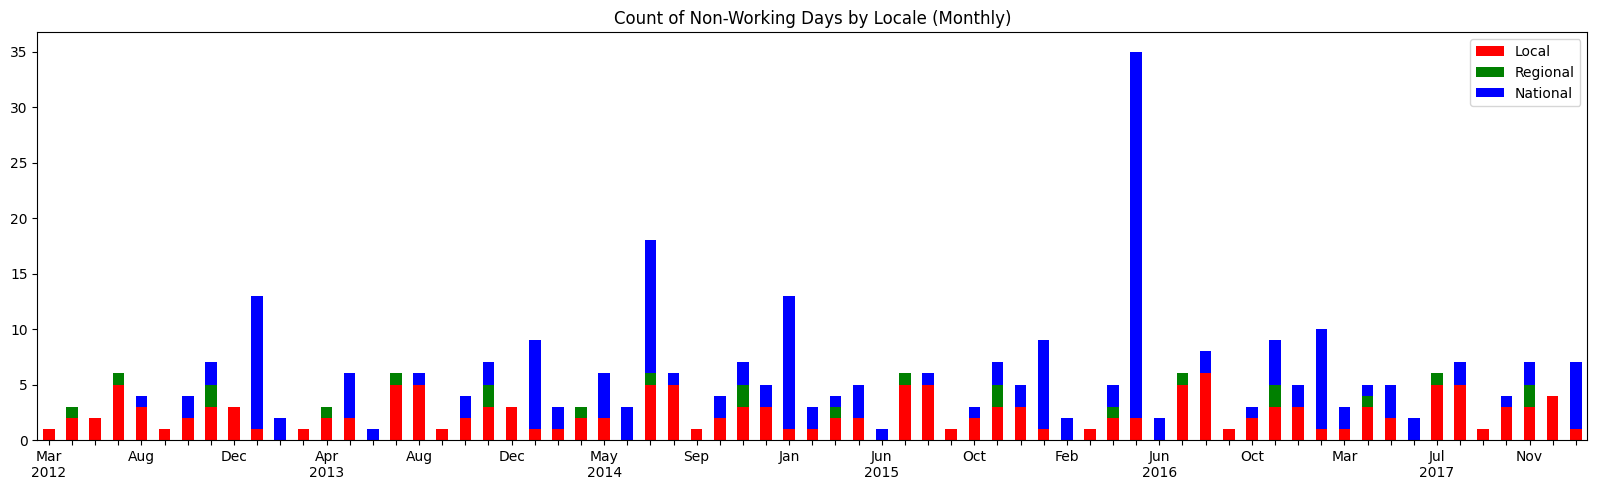

In [108]:

fig, ax = plt.subplots(figsize=(20, 6))
pivot_counts.plot(ax=ax, kind='bar', stacked=True, color=['red', 'green', 'blue'])


# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(pivot_counts.index)
# Every 4th ticklable shows the month and day
ticklabels[::4] = [item.strftime('%b') for item in pivot_counts.index[::4]]
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b')+item.strftime('\n%Y') for item in pivot_counts.index[::12]]
ax.xaxis.set_major_formatter(FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()



# Set x-axis label
ax.set_xlabel('')

# # Set y-axis label
# plt.ylabel('Count of Non-Working Days')

# Set title
ax.set_title('Count of Non-Working Days by Locale (Monthly)')

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

plt.grid(False)

# Show the plot
plt.show();


In [109]:
total_daily_sales_df['date'].dt.year().unique()


date
i32
2013
2014
2015
2016
2017


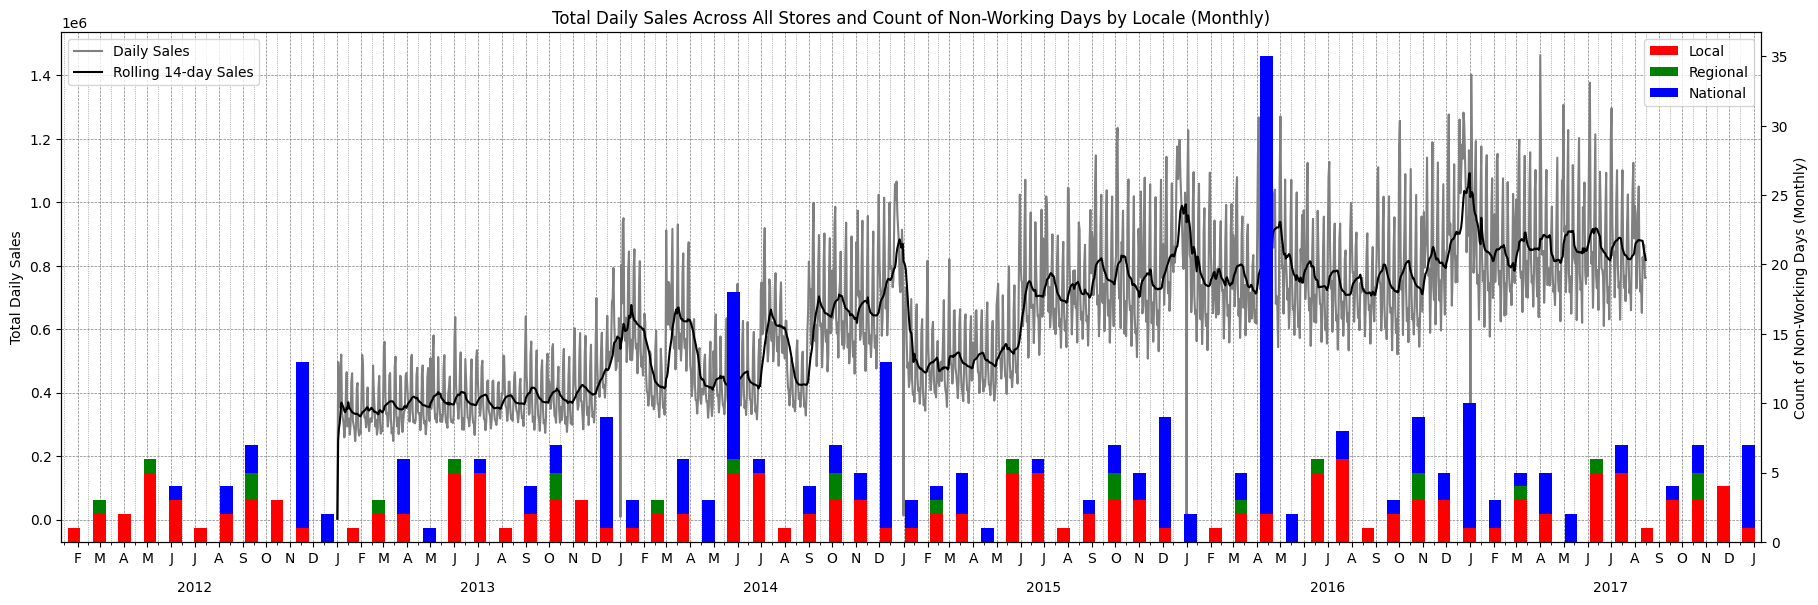

In [110]:
# Convert to Python datetime objects
min_date = pivot_counts.index.min().to_pydatetime()
max_date= pivot_counts.index.max().to_pydatetime()

# Convert datetime objects to floating-point numbers
min_xaxis = date2num(min_date)
max_xaxis = date2num(max_date)


# Create the figure and axis
fig = plt.figure(figsize=(20,6))
ax  = fig.add_axes([0.1, 0.1, 0.85, 0.85])
ax1 = fig.add_axes([0.1, 0.1, 0.85, 0.85])
ax1.set_facecolor('none')


# Plot the first line plot
sns.lineplot(data=total_daily_sales_df, x='date', y='sales', color='grey', label='Daily Sales', ax=ax)
sns.lineplot(data=total_daily_sales_df, x='date', y='rolling_avg', color='black', label='Rolling 14-day Sales', ax=ax)

# Plot the stacked bar chart
pivot_counts.plot(ax=ax1, kind='bar', stacked=True, color=['red', 'green', 'blue'])
# Set title and labels
ax.set_title('Total Daily Sales Across All Stores and Count of Non-Working Days by Locale (Monthly)')
ax1.set_xticks([])
ax1.set_xticklabels([])
ax.set_xlabel('')
ax1.set_xlabel('')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax.set_ylabel('Total Daily Sales')
ax1.set_ylabel('Count of Non-Working Days (Monthly)')

ax.set_xlim(min_xaxis-50, max_xaxis+10)
# ax.set_xlim(min_xaxis, max_xaxis)


# Format the x-axis
ax.xaxis.set_major_locator(MonthLocator(interval=1))  # Set major ticks at every month
ax.xaxis.set_major_formatter(FuncFormatter(format_month_name))  # Abbreviated month names

# Add minor gridlines at 15-day intervals
ax.xaxis.set_minor_locator(MonthLocator(bymonthday=15))
ax.xaxis.grid(True, which='minor', linestyle='dotted', linewidth=0.5, color='grey')

# Add major gridlines
ax.xaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')

# Add year labels manually
years = total_daily_sales_df['date'].dt.year().unique()  # Unique years
years = np.append(2012, years) # Adding the year 2012 as it is in the holiday data frame
year_positions = [pd.to_datetime(str(year), format='%Y') + relativedelta(months=6) for year in years]

for pos, year in zip(year_positions, years):
    ax.text(pos, ax.get_ylim()[0] - ax.get_ylim()[1] * 0.08, year, ha='center', va='top')  # Add the year text below the x-axis


# Make the Jan tick longer (index 0 corresponds to Jan)
# ax.tick_params(axis='x', which='major', length=[15 if i == 0 else 5 for i in range(len(year_positions))])

plt.show();


In [111]:
print(holiday_events_df['transferred'].value_counts())

shape: (2, 2)
┌─────────────┬───────┐
│ transferred ┆ count │
│ ---         ┆ ---   │
│ bool        ┆ u32   │
╞═════════════╪═══════╡
│ true        ┆ 12    │
│ false       ┆ 338   │
└─────────────┴───────┘


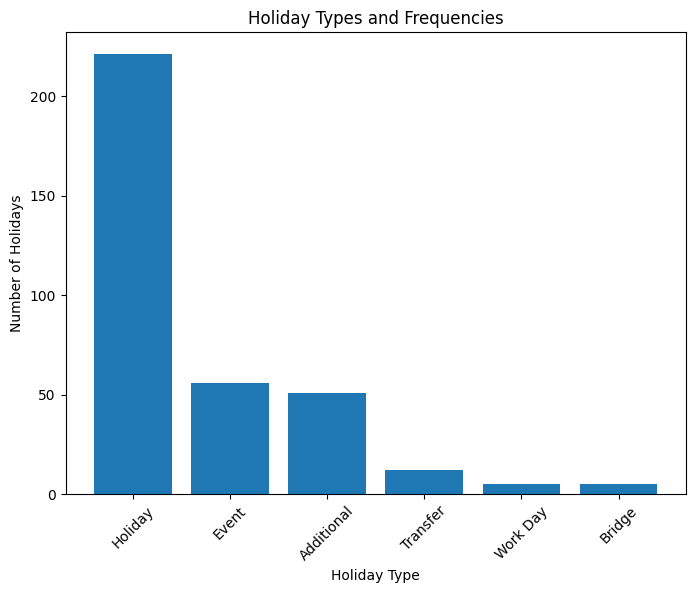

In [112]:
# Group by 'type' and count the number of holidays for each type
holidays_by_type = holiday_events_df['type'].value_counts().sort('count', descending=True)

# Plot the count of holidays for each type
plt.figure(figsize=(8, 6))
plt.bar(holidays_by_type.select(pl.col('type')).to_series(), holidays_by_type.select(pl.col('count')).to_series())
plt.xlabel('Holiday Type')
plt.ylabel('Number of Holidays')
plt.title('Holiday Types and Frequencies')
plt.xticks(rotation=45)
plt.show()


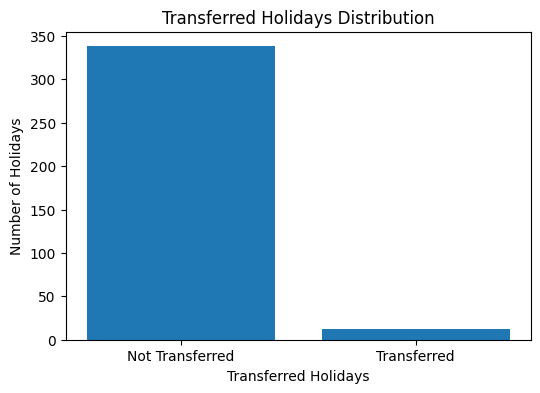

In [113]:
# Group by 'transferred' and count the number of holidays marked as transferred
holidays_transferred = holiday_events_df['transferred'].value_counts().sort('count', descending=True)

# Plot the count of holidays marked as transferred
plt.figure(figsize=(6, 4))
plt.bar(holidays_transferred.select(pl.col('transferred')).to_series(), holidays_transferred.select(pl.col('count')).to_series())
plt.xlabel('Transferred Holidays')
plt.ylabel('Number of Holidays')
plt.title('Transferred Holidays Distribution')
plt.xticks([0, 1], ['Not Transferred', 'Transferred'])
plt.show()


### Transactions

In [114]:
transactions_df=pl.read_csv('../data/input/transactions.csv', dtypes={'store_nbr':str}, try_parse_dates=True)

In [115]:
print(transactions_df.head())

shape: (5, 3)
┌────────────┬───────────┬──────────────┐
│ date       ┆ store_nbr ┆ transactions │
│ ---        ┆ ---       ┆ ---          │
│ date       ┆ str       ┆ i64          │
╞════════════╪═══════════╪══════════════╡
│ 2013-01-01 ┆ 25        ┆ 770          │
│ 2013-01-02 ┆ 1         ┆ 2111         │
│ 2013-01-02 ┆ 2         ┆ 2358         │
│ 2013-01-02 ┆ 3         ┆ 3487         │
│ 2013-01-02 ┆ 4         ┆ 1922         │
└────────────┴───────────┴──────────────┘


In [116]:
print(transactions_df.describe())

shape: (9, 4)
┌────────────┬────────────┬───────────┬──────────────┐
│ statistic  ┆ date       ┆ store_nbr ┆ transactions │
│ ---        ┆ ---        ┆ ---       ┆ ---          │
│ str        ┆ str        ┆ str       ┆ f64          │
╞════════════╪════════════╪═══════════╪══════════════╡
│ count      ┆ 83488      ┆ 83488     ┆ 83488.0      │
│ null_count ┆ 0          ┆ 0         ┆ 0.0          │
│ mean       ┆ 2015-05-20 ┆ null      ┆ 1694.602158  │
│ std        ┆ null       ┆ null      ┆ 963.286644   │
│ min        ┆ 2013-01-01 ┆ 1         ┆ 5.0          │
│ 25%        ┆ 2014-03-27 ┆ null      ┆ 1046.0       │
│ 50%        ┆ 2015-06-08 ┆ null      ┆ 1393.0       │
│ 75%        ┆ 2016-07-14 ┆ null      ┆ 2079.0       │
│ max        ┆ 2017-08-15 ┆ 9         ┆ 8359.0       │
└────────────┴────────────┴───────────┴──────────────┘


In [117]:
q = (
    transactions_df.lazy().with_columns(pl.col('date').dt.round(every='1d'))
    .group_by('date', maintain_order=True).agg(pl.col('transactions').sum())

)

total_daily_transactions_df = q.collect()
window_size = 15  # You can adjust the window size as needed
total_daily_transactions_df = total_daily_transactions_df.with_columns(
    rolling_avg=pl.col('transactions').rolling_mean(window_size=window_size, min_periods=1)
)

print(total_daily_transactions_df)


shape: (1_682, 3)
┌────────────┬──────────────┬──────────────┐
│ date       ┆ transactions ┆ rolling_avg  │
│ ---        ┆ ---          ┆ ---          │
│ date       ┆ i64          ┆ f64          │
╞════════════╪══════════════╪══════════════╡
│ 2013-01-01 ┆ 770          ┆ 770.0        │
│ 2013-01-02 ┆ 93215        ┆ 46992.5      │
│ 2013-01-03 ┆ 78504        ┆ 57496.333333 │
│ 2013-01-04 ┆ 78494        ┆ 62745.75     │
│ 2013-01-05 ┆ 93573        ┆ 68911.2      │
│ 2013-01-06 ┆ 90464        ┆ 72503.333333 │
│ 2013-01-07 ┆ 75597        ┆ 72945.285714 │
│ 2013-01-08 ┆ 72325        ┆ 72867.75     │
│ …          ┆ …            ┆ …            │
│ 2017-08-09 ┆ 85452        ┆ 89928.0      │
│ 2017-08-10 ┆ 83064        ┆ 89991.4      │
│ 2017-08-11 ┆ 89551        ┆ 90711.933333 │
│ 2017-08-12 ┆ 89927        ┆ 90760.6      │
│ 2017-08-13 ┆ 85993        ┆ 89811.666667 │
│ 2017-08-14 ┆ 85448        ┆ 89181.6      │
│ 2017-08-15 ┆ 86561        ┆ 89046.133333 │
└────────────┴──────────────┴────────

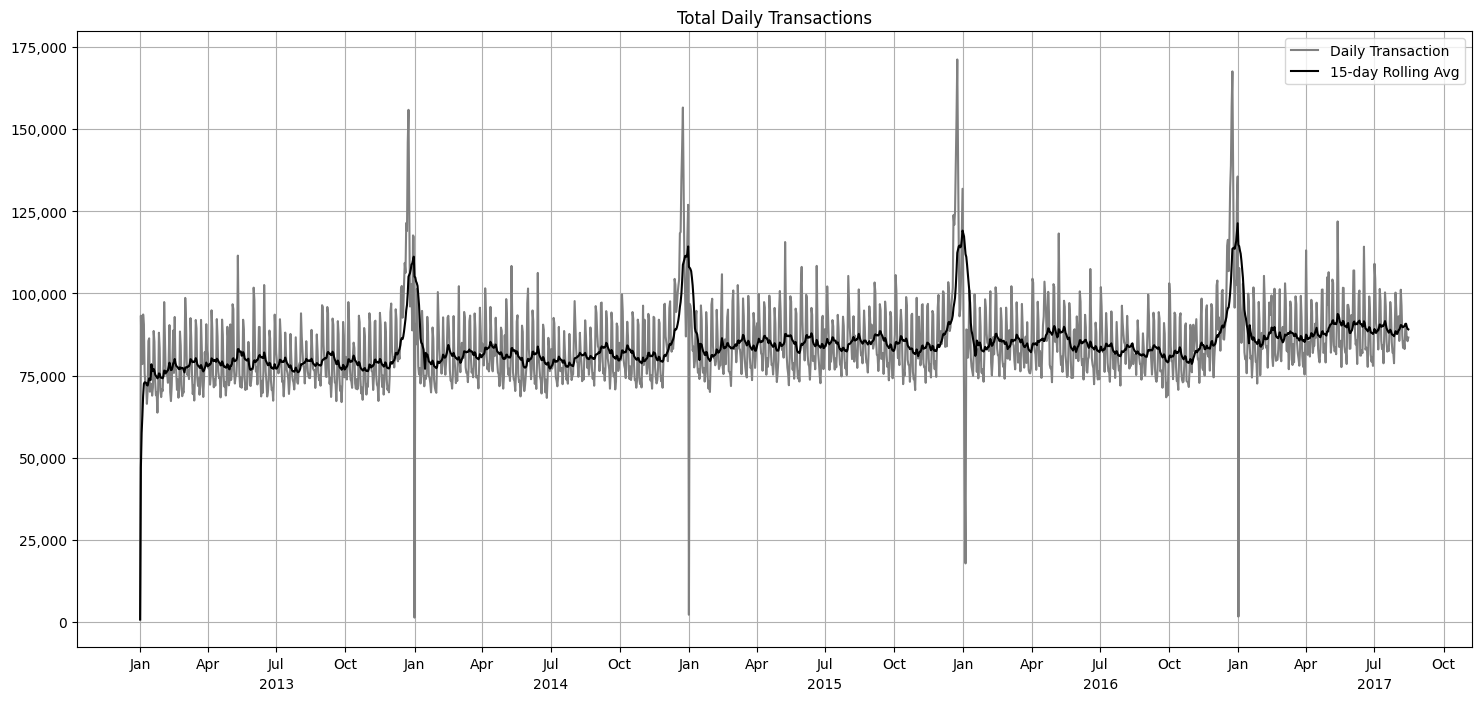

In [118]:
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(ax=ax, data=total_daily_transactions_df.to_pandas(), x='date', y='transactions', label='Daily Transaction', color='grey')
sns.lineplot(ax=ax, data=total_daily_transactions_df.to_pandas(), x='date', y='rolling_avg', label= f'{window_size}' + '-day Rolling Avg', color='black')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Total Daily Transactions')
ax.grid(which='both', visible=True, axis='both')

# Format the x-axis
ax.xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))  # Set major ticks at every month
ax.xaxis.set_major_formatter(DateFormatter('%b'))  # Abbreviated month names

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# Add year labels manually
years = total_daily_transactions_df.select(pl.col("date").dt.year().unique()).to_series()  # Unique years
year_positions = [total_daily_transactions_df.filter(total_daily_transactions_df['date'].dt.year() == year).select(pl.col('date'))[0].item() + relativedelta(months=6) for year in years]


# Set the x-ticks to correspond to the dates and adjust the tick positions for better alignment
# ax.set_xticks(year_positions)
# ax.set_xticklabels([])  # Empty list to remove the default x-axis labels
for pos, year in zip(year_positions, years):
    ax.text(pos, ax.get_ylim()[0] - ax.get_ylim()[1]*0.05, year, ha='center', va='top')  # Add the year text below the x-axis
plt.show;


In [119]:
transactions_df = transactions_df.with_columns(
    month = pl.col('date').dt.strftime("%B"),
    quarter = pl.col('date').dt.quarter().map_elements(lambda x: 'Q' + f'{x}', return_dtype=pl.Utf8),
    year = pl.col('date').dt.year().cast(pl.Utf8),
    dayofweek = pl.col('date').dt.weekday().map_elements(lambda x: day_names[x-1], return_dtype=pl.Utf8),
    day = pl.col('date').dt.day().cast(pl.Utf8)
)
print(transactions_df)


shape: (83_488, 8)
┌────────────┬───────────┬──────────────┬─────────┬─────────┬──────┬───────────┬─────┐
│ date       ┆ store_nbr ┆ transactions ┆ month   ┆ quarter ┆ year ┆ dayofweek ┆ day │
│ ---        ┆ ---       ┆ ---          ┆ ---     ┆ ---     ┆ ---  ┆ ---       ┆ --- │
│ date       ┆ str       ┆ i64          ┆ str     ┆ str     ┆ str  ┆ str       ┆ str │
╞════════════╪═══════════╪══════════════╪═════════╪═════════╪══════╪═══════════╪═════╡
│ 2013-01-01 ┆ 25        ┆ 770          ┆ January ┆ Q1      ┆ 2013 ┆ Tuesday   ┆ 1   │
│ 2013-01-02 ┆ 1         ┆ 2111         ┆ January ┆ Q1      ┆ 2013 ┆ Wednesday ┆ 2   │
│ 2013-01-02 ┆ 2         ┆ 2358         ┆ January ┆ Q1      ┆ 2013 ┆ Wednesday ┆ 2   │
│ 2013-01-02 ┆ 3         ┆ 3487         ┆ January ┆ Q1      ┆ 2013 ┆ Wednesday ┆ 2   │
│ 2013-01-02 ┆ 4         ┆ 1922         ┆ January ┆ Q1      ┆ 2013 ┆ Wednesday ┆ 2   │
│ 2013-01-02 ┆ 5         ┆ 1903         ┆ January ┆ Q1      ┆ 2013 ┆ Wednesday ┆ 2   │
│ 2013-01-02 ┆ 6        

In [120]:
grouped_monthly_transactions_df = transactions_df.group_by('month', maintain_order=True).agg(pl.col('transactions').sum())
grouped_yearly_transactions_df = transactions_df.group_by('year', maintain_order=True).agg(pl.col('transactions').sum())
grouped_dayofweek_transactions_df = transactions_df.group_by('dayofweek', maintain_order=True).agg(pl.col('transactions').sum())
grouped_day_transactions_df = transactions_df.group_by('day', maintain_order=True).agg(pl.col('transactions').sum())
grouped_quarterly_transactions_df = transactions_df.group_by('quarter', maintain_order=True).agg(pl.col('transactions').sum())
print(grouped_monthly_transactions_df)

shape: (12, 2)
┌───────────┬──────────────┐
│ month     ┆ transactions │
│ ---       ┆ ---          │
│ str       ┆ i64          │
╞═══════════╪══════════════╡
│ January   ┆ 12156198     │
│ February  ┆ 11707934     │
│ March     ┆ 12917913     │
│ April     ┆ 12633531     │
│ May       ┆ 13112679     │
│ June      ┆ 12482179     │
│ July      ┆ 12827206     │
│ August    ┆ 11545571     │
│ September ┆ 9811819      │
│ October   ┆ 10048234     │
│ November  ┆ 9877873      │
│ December  ┆ 12357808     │
└───────────┴──────────────┘


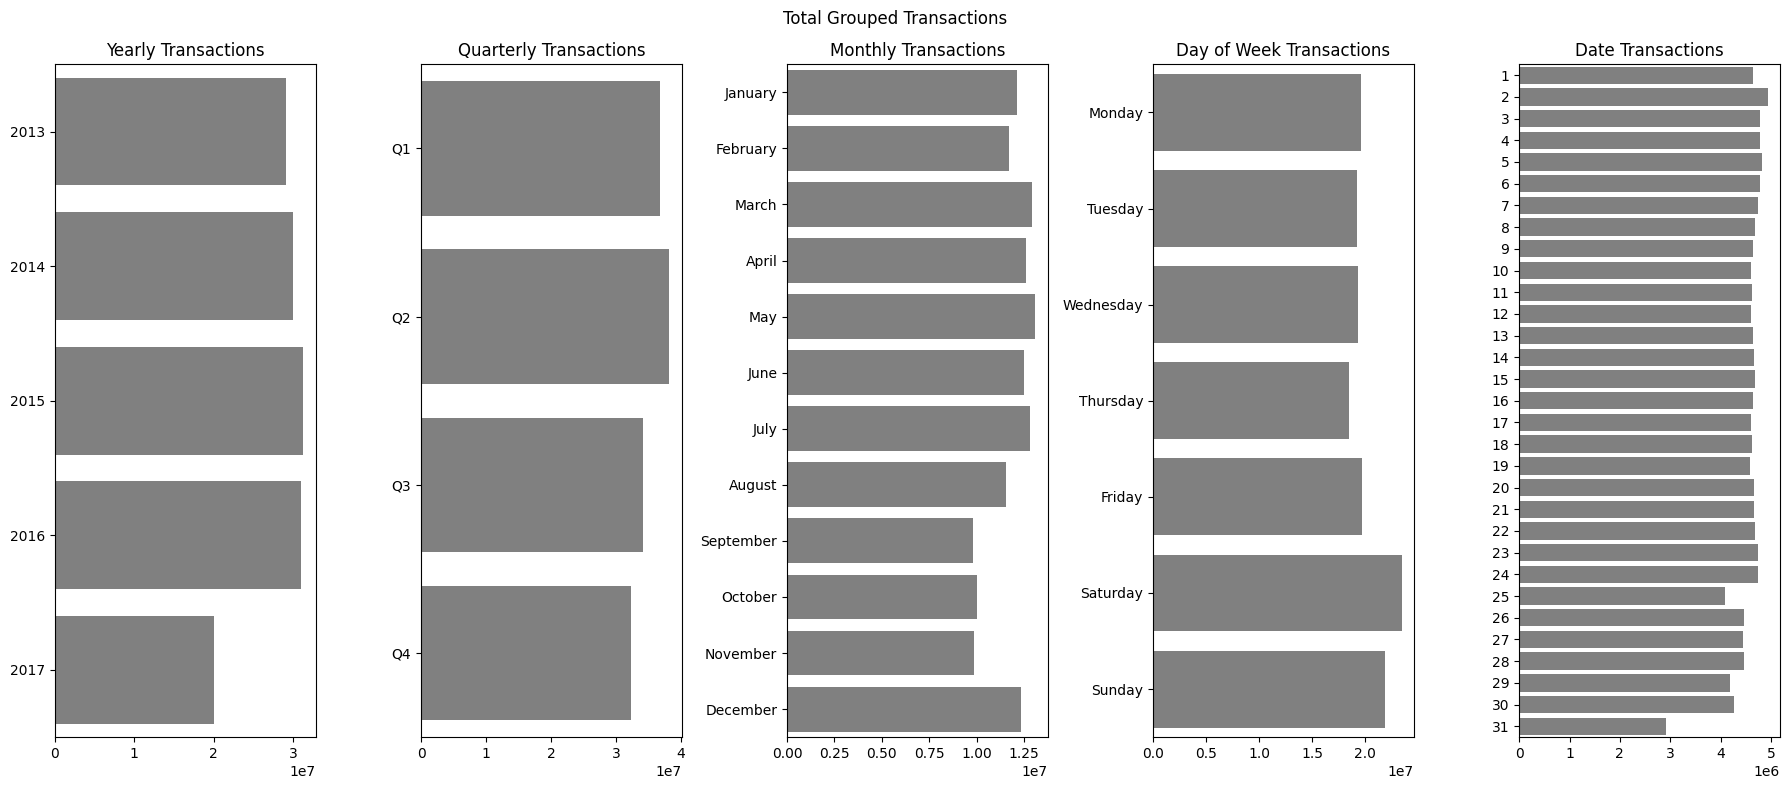

In [121]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(18,8))
sns.barplot(data=grouped_yearly_transactions_df.to_pandas(), x='transactions', y='year', color='grey',  ax=ax1)
sns.barplot(data=grouped_quarterly_transactions_df.to_pandas(), x='transactions', y='quarter', color='grey', order=['Q1', 'Q2', 'Q3', 'Q4'], ax=ax2)
sns.barplot(data=grouped_monthly_transactions_df.to_pandas(), x='transactions', y='month', color='grey',  ax=ax3)
sns.barplot(data=grouped_dayofweek_transactions_df.to_pandas(), x='transactions', y='dayofweek', color='grey', order=day_names, ax=ax4)
sns.barplot(data=grouped_day_transactions_df.to_pandas(), x='transactions', y='day', color='grey',  order=day_string, ax=ax5)

ax1.set_title('Yearly Transactions')
ax2.set_title('Quarterly Transactions')
ax3.set_title('Monthly Transactions')
ax4.set_title('Day of Week Transactions')
ax5.set_title('Date Transactions')

# Turn off x and y-axis labels
ax1.set(xlabel='', ylabel='')
ax2.set(xlabel='', ylabel='')
ax3.set(xlabel='', ylabel='')
ax4.set(xlabel='', ylabel='')
ax5.set(xlabel='', ylabel='')
fig.suptitle('Total Grouped Transactions')
fig.tight_layout()

In [122]:
transactions_sales_merged = total_daily_sales_df.join(total_daily_transactions_df, on='date', how='left')
no_nulls_mask = transactions_sales_merged.select(pl.all().is_not_null()).to_series()
print(transactions_sales_merged.filter(no_nulls_mask))
# print(transactions_sales_merged.with_columns(pl.all_horizontal(pl.col('*').is_not_null())).filter(pl.col('all')=='false')
# )

shape: (1_684, 5)
┌────────────┬───────────────┬───────────────┬──────────────┬───────────────────┐
│ date       ┆ sales         ┆ rolling_avg   ┆ transactions ┆ rolling_avg_right │
│ ---        ┆ ---           ┆ ---           ┆ ---          ┆ ---               │
│ date       ┆ f64           ┆ f64           ┆ i64          ┆ f64               │
╞════════════╪═══════════════╪═══════════════╪══════════════╪═══════════════════╡
│ 2013-01-01 ┆ 2511.618999   ┆ 2511.618999   ┆ 770          ┆ 770.0             │
│ 2013-01-02 ┆ 496092.417944 ┆ 249302.018472 ┆ 93215        ┆ 46992.5           │
│ 2013-01-03 ┆ 361461.231124 ┆ 286688.422689 ┆ 78504        ┆ 57496.333333      │
│ 2013-01-04 ┆ 354459.677093 ┆ 303631.23629  ┆ 78494        ┆ 62745.75          │
│ 2013-01-05 ┆ 477350.121229 ┆ 338375.013278 ┆ 93573        ┆ 68911.2           │
│ 2013-01-06 ┆ 519695.401088 ┆ 368595.077913 ┆ 90464        ┆ 72503.333333      │
│ 2013-01-07 ┆ 336122.801066 ┆ 363956.18122  ┆ 75597        ┆ 72945.285714      

In [123]:
transactions_sales_merged = transactions_sales_merged.with_columns(pl.col("*").fill_null(strategy="forward"))

In [124]:
print(transactions_sales_merged.filter(
    pl.col('date').is_between(datetime(2015, 12, 28), datetime(2016, 1, 6))
))

shape: (10, 5)
┌────────────┬───────────────┬───────────────┬──────────────┬───────────────────┐
│ date       ┆ sales         ┆ rolling_avg   ┆ transactions ┆ rolling_avg_right │
│ ---        ┆ ---           ┆ ---           ┆ ---          ┆ ---               │
│ date       ┆ f64           ┆ f64           ┆ i64          ┆ f64               │
╞════════════╪═══════════════╪═══════════════╪══════════════╪═══════════════════╡
│ 2015-12-28 ┆ 789684.912782 ┆ 963883.86058  ┆ 95257        ┆ 114009.866667     │
│ 2015-12-29 ┆ 870762.025758 ┆ 968108.739408 ┆ 104623       ┆ 114259.733333     │
│ 2015-12-30 ┆ 1.0300e6      ┆ 985982.581006 ┆ 118947       ┆ 116286.866667     │
│ 2015-12-31 ┆ 964641.541501 ┆ 993461.959032 ┆ 131826       ┆ 119093.533333     │
│ 2016-01-01 ┆ 16433.394     ┆ 936792.21941  ┆ 131826       ┆ 119093.533333     │
│ 2016-01-02 ┆ 1.0667e6      ┆ 949157.042421 ┆ 69628        ┆ 117337.2          │
│ 2016-01-03 ┆ 1.2267e6      ┆ 958529.342566 ┆ 69628        ┆ 117337.2          │
│

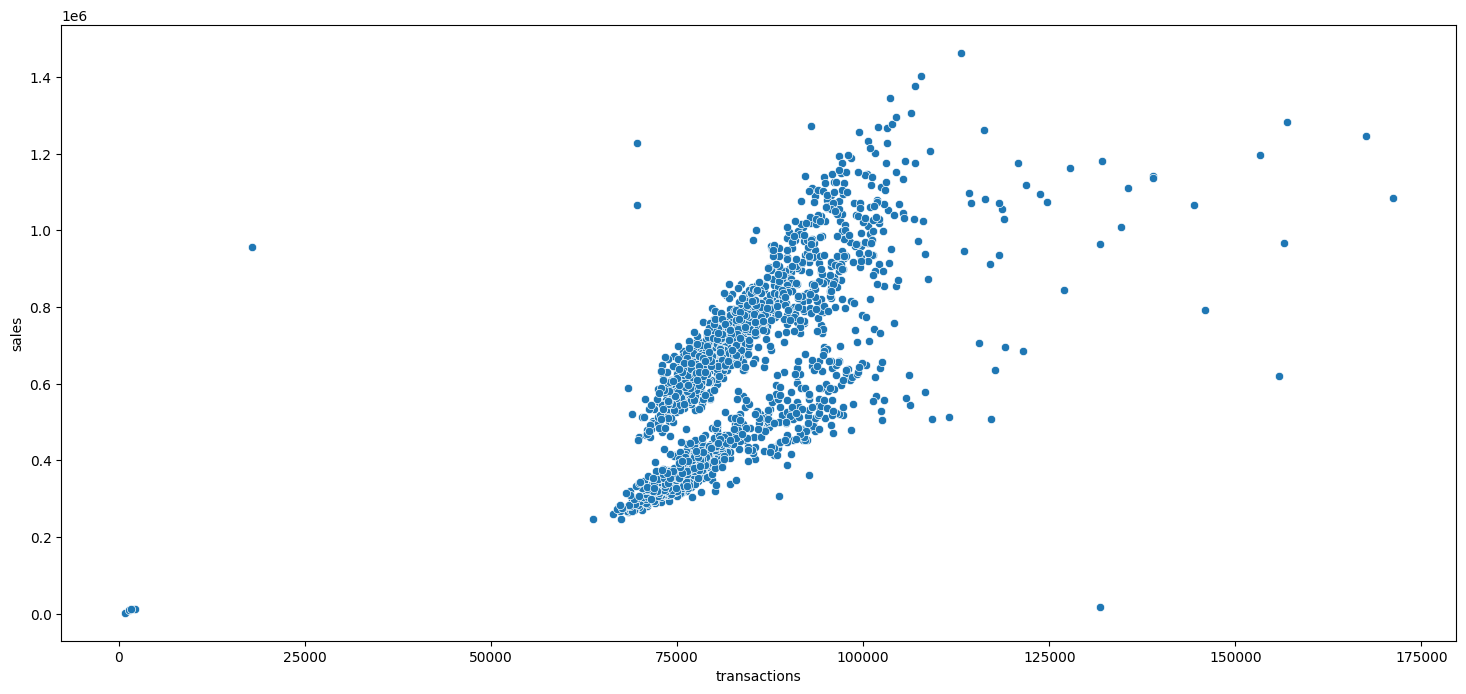

In [125]:
fig, ax = plt.subplots(figsize = (18,8))

sns.scatterplot(x=transactions_sales_merged['transactions'], y = transactions_sales_merged['sales'])
plt.show();
# ax.set_yscale('log')